In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.notebook import tqdm as tqdm
from PIL import Image
import os
from pathlib import Path
from datetime import datetime
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device('cpu')

print(device)

cuda


In [21]:
save_dir = str(Path(fr"./runs/exp"))

In [22]:
num_workers = 8
batch_size = 32
epoch_num = 100

LR = 1e-4
EPS = 1e-9
LR_STEP = 20
LR_GAMMA = 0.7

In [23]:
class CustomDataset(Dataset):
    def __init__(self):
        self.data = pd.read_csv('data/train_in.csv').drop(['Serial No.'], axis=1)  # 從csv文件中讀取數據
        self.label = pd.read_csv('data/train_out.csv') # 從csv文件中讀取數據
        self.reshaped_data = torch.from_numpy(self.data.values.reshape(-1, 8, 2)).to(torch.float32)

    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        data = self.reshaped_data[idx]
        label = torch.tensor(self.label.iloc[idx, 1], dtype=torch.long)
        return data, label  # 返回圖像和標籤

In [24]:
img_name = f"data/img_in/0.png"
img = Image.open(img_name).convert("RGB")
img.size

(640, 480)

In [25]:
from PIL import Image
from torchvision import transforms
import pandas as pd
from torch.utils.data import Dataset
import torch

class CustomImageDataset(Dataset):
    def __init__(self):
        self.data = pd.read_csv('data/train_in.csv').drop(['Serial No.'], axis=1)  # 從csv文件中讀取數據
        self.label = pd.read_csv('data/train_out.csv') # 從csv文件中讀取數據
        self.reshaped_data = torch.from_numpy(self.data.values.reshape(-1, 8, 2)).to(torch.float32)

        # 圖像轉換，可以根據實際情況修改
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 正則化
        ])
        
    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        data = self.reshaped_data[idx]
        label = torch.tensor(self.label.iloc[idx, 1], dtype=torch.long)
        
        # 加載圖像，並轉換為Tensor
        img_name = f"data/img_in/{idx}.png"
        img = Image.open(img_name).resize((120, 160)).convert("RGB")
        img = self.transform(img)
        
        return (data, img), label  # 返回序列、圖像和標籤


In [26]:
# 創建一個自定義的圖像數據集對象
# dataset = CustomDataset()
dataset = CustomImageDataset()

# 計算訓練集的大小，通常是數據集的80%
train_size = int(0.8 * len(dataset))

# 驗證集的大小就是剩餘的部分
val_size = len(dataset) - train_size

# 使用random_split函數隨機分割數據集為訓練集和驗證集
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

# 創建一個數據加載器的字典，對訓練集和驗證集分別進行加載
# shuffle參數設為True表示在每個訓練時期開始時，數據加載器會重新洗牌數據
dataloaders = {x: DataLoader(y, batch_size=batch_size, shuffle=z) 
               for x, y, z in zip(['train', 'valid'], [train_dataset, valid_dataset], [True, False])}

# 打印整個數據集的大小
print(len(dataset)) 


7494


In [27]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNNModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN 層
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # 全連接層，將 RNN 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 獲取 RNN 的輸出
        out, _ = self.rnn(x, h0)

        # 只需要最後一步的輸出給全連接層
        out = out[:, -1, :]

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out

In [28]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 層
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # 全連接層，將 LSTM 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隱藏狀態和 cell 狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 獲取 LSTM 的輸出
        out, _ = self.lstm(x, (h0, c0))

        # 只需要最後一步的輸出給全連接層
        out = out[:, -1, :]

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out


In [29]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRUModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 將RNN換成GRU
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # 全連接層，將 GRU 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化隱藏狀態
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 獲取 GRU 的輸出
        out, _ = self.gru(x, h0)

        # 只需要最後一步的輸出給全連接層
        out = out[:, -1, :]

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out


In [30]:
from torchvision.models import resnet50

class LSTMCNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM 層
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.resnet = resnet50(num_classes=hidden_size)

        # 全連接層，將 LSTM 的輸出轉換為類別預測
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        
        # 將輸入拆分為圖像和序列
        seq, img = x

        # 初始化隱藏狀態和 cell 狀態
        h0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_size).to(seq.device)
        c0 = torch.zeros(self.num_layers, seq.size(0), self.hidden_size).to(seq.device)

        # 獲取 LSTM 的輸出
        out_lstm, _ = self.lstm(seq, (h0, c0))
        # 只需要最後一步的輸出
        out_lstm = out_lstm[:, -1, :]

        # 獲取 ResNet 的輸出
        out_resnet = self.resnet(img)

        # 將 LSTM 和 ResNet 的輸出連接起來
        out = torch.cat((out_lstm, out_resnet), dim=1)

        # 通過全連接層獲得最終的類別預測
        out = self.fc(out)

        return out


In [31]:
# model_name =  RNNModel
model_name =  LSTMCNNModel

# model_name =  GRUModel
model_kwargs = {
    'input_size': 2,    # 輸入的特徵維度
    'hidden_size': 64,  # 隱藏層的大小 
    'output_size': 10,  # 輸出的類別數量
    'num_layers': 10,    # RNN 的層數
}


# 建立模型
# model = RNNModel(**model_kwargs)
# model = LSTMModel(**model_kwargs)
# model = GRUModel(**model_kwargs)
model = LSTMCNNModel(**model_kwargs)


# 選擇優化器，使用AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, eps=EPS)

# 使用SGD作為優化器
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# 使用ReduceLROnPlateau學習率調度器，當某指標停止改進時，減少學習率
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.5, 
                                                          patience=30, 
                                                          verbose=True, 
                                                          threshold=0.0001, 
                                                          threshold_mode='rel', 
                                                          cooldown=50, 
                                                          min_lr=0, 
                                                          eps=EPS)

# 使用ReduceLROnPlateau學習率調度器，當epoch計數器到一定值後會更先學習率
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma=LR_GAMMA)

# 選擇損失函數，這裡我們使用交叉熵損失函數
criterion = nn.CrossEntropyLoss()


In [32]:
# 導入ptflops庫，用於獲取模型的複雜度信息
from ptflops import get_model_complexity_info

# 指定使用第一塊GPU（索引為0）
with torch.cuda.device(0):
    # 獲取模型的複雜度信息，包括MACs和參數數量
    macs, params = get_model_complexity_info(model, (8, 2), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
    # 打印模型的計算複雜度（MACs）
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    # 打印模型的參數數量
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))


ValueError: not enough values to unpack (expected 2, got 1)

In [33]:
ckpt = {
    'epoch': 0,
    'model_name': model_name,
    'model_args': model_kwargs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'criterion': criterion,
    'history': {
        'train_loss': [], 
        'valid_loss': [],
        'train_top1_accuracy': [], 
        'valid_top1_accuracy': [],
        'valid_loss_min': np.Inf,
        'train_loss_min': np.Inf,
        'best_acc': 0.0,
    },
    'readme': "",
    'date': datetime.now().isoformat(),
}

In [34]:
def increment_path(path, exist_ok=False, sep='', mkdir=False):
    # 增加文件或目錄路徑，例如將 runs/exp 變成 runs/exp{sep}2, runs/exp{sep}3, ... 等等。
    path = Path(path)  # 使路徑符合作業系統

    if path.exists() and not exist_ok:
        # 如果路徑存在且不允許重複，則進行增量操作
        path, suffix = (path.with_suffix(''), path.suffix) if path.is_file() else (path, '')

        for n in range(2, 9999):
            p = f'{path}{sep}{n}{suffix}'  # 增加路徑
            if not os.path.exists(p):  # 如果新路徑不存在，則跳出迴圈
                break
        path = Path(p)  # 將新路徑轉換為 Path 物件

    if mkdir:
        # 如果 mkdir 為 True，則創建新目錄
        path.mkdir(parents=True, exist_ok=True)  

    return str(path)  # 返回字符串形式的路徑

In [35]:
def train(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=100,
          dtype=torch.float32, 
          device='cpu'):

    # 將儲存目錄轉換為 Path 物件
    save_dir = Path(save_dir)
    # 使用 increment_path 增加儲存目錄的路徑，避免複寫先前資料
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)

    # 將模型移動到指定的裝置上，同步model的資料型別(要跟data 相同，不然會報錯)
    model = model.to(dtype=dtype).to(device)

    # 以存檔來初始化模型、優化器、學習率調度器和損失函數，如果程式碼意外停止，也能以ckpt來繼續訓練
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    # 開始訓練循環
    for epoch in range(1, num_epochs + 1):

        # 初始化訓練和驗證的損失和準確率
        train_loss = 0.0
        valid_loss = 0.0
        train_top1 = 0.0
        valid_top1 = 0.0
        valid_top1_acc = 0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # 設定模型為訓練模式
        model.train()
        for x, y in tqdm(dataloaders['train']):
            # 將優化器中的梯度清零
            optimizer.zero_grad()
            
            # 將輸入和標籤移動到指定的裝置上
            if isinstance(x, list):
                x = [i.to(device) for i in x]  # 將每個張量移到指定的裝置上
            else:
                x = x.to(device)
            y = y.to(device)

            # 前向傳播，計算預測和損失
            predictions = model(x)
            loss = criterion(predictions, y)
            # 反向傳播，計算梯度
            loss.backward()
            # 使用優化器更新權重
            optimizer.step()

            # 累計訓練損失和準確率
            train_loss += loss.item() * x.size(0)
            train_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 設定模型為驗證模式
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(dataloaders['valid']):
                # 將輸入和標籤移動到指定的裝置上
                x = x.to(device)
                y = y.to(device)

                # 前向傳播，計算預測和損失
                predictions = model(x)
                loss = criterion(predictions, y)

                # 累計驗證損失和準確率
                valid_loss += loss.item() * x.size(0)
                valid_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 如果有設置學習率調度器，則以驗證損失作為指標調整學習率
        if (lr_scheduler):
            lr_scheduler.step(valid_loss)

        # 計算訓練和驗證的平均損失和準確率
        train_loss = train_loss / len(dataloaders['train'].sampler)
        train_top1_acc = train_top1 / len(dataloaders['train'].sampler)
        # 將這一輪的訓練和驗證損失和準確率添加到歷史記錄中
        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['train_top1_accuracy'].append(train_top1_acc)

        if (len(dataloaders['valid'].sampler)):
            valid_loss = valid_loss / len(dataloaders['valid'].sampler)
            valid_top1_acc = valid_top1 / len(dataloaders['valid'].sampler)
            ckpt['history']['valid_loss'].append(valid_loss)
            ckpt['history']['valid_top1_accuracy'].append(valid_top1_acc)

        # 打印這一輪的訓練和驗證損失和準確率
        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        print(
            f'Train top1 acc -> {train_top1_acc:.6f}      \
                Validation top1 acc -> {valid_top1_acc:.6f}')

        # 更新和保存檢查點信息
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # 如果驗證損失降低，則保存模型
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('valid_best.pth')))

        # 如果訓練損失降低，則保存模型
        if train_loss <= ckpt['history']['train_loss_min']:
            print(
                f"Train loss decreased ({ckpt['history']['train_loss_min']:.6f} \
                    --> {train_loss:.6f}).  Saving model ...")
            ckpt['history']['train_loss_min'] = train_loss
            torch.save(ckpt, str(Path(save_dir) / Path('train_best.pth')))

        # 每10輪保存一次檢查點
        if (epoch) % 10 == 0:
            torch.save(ckpt, str(Path(save_dir) / Path(f'ckpt_{epoch}.pth')))
        torch.save(ckpt, str(Path(save_dir) / Path(f'last.pth')))

In [36]:
def trainv2(ckpt, 
          save_dir, 
          model, 
          dataloaders, 
          optimizer, 
          lr_scheduler=None,
          num_epochs=100,
          dtype=torch.float32, 
          device='cpu'):

    # 將儲存目錄轉換為 Path 物件
    save_dir = Path(save_dir)
    # 使用 increment_path 增加儲存目錄的路徑，避免複寫先前資料
    save_dir = increment_path(
        Path(save_dir), exist_ok=(False if ckpt['epoch'] == 0 else True), mkdir=True)

    # 將模型移動到指定的裝置上，同步model的資料型別(要跟data 相同，不然會報錯)
    model = model.to(dtype=dtype).to(device)

    # 以存檔來初始化模型、優化器、學習率調度器和損失函數，如果程式碼意外停止，也能以ckpt來繼續訓練
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if (lr_scheduler):
        lr_scheduler.load_state_dict(ckpt['lr_scheduler_state_dict'])
    criterion = ckpt['criterion']

    # 開始訓練循環
    for epoch in range(1, num_epochs + 1):

        # 初始化訓練和驗證的損失和準確率
        train_loss = 0.0
        valid_loss = 0.0
        train_top1 = 0.0
        valid_top1 = 0.0
        valid_top1_acc = 0
        print(f"running epoch: {ckpt['epoch'] + 1}")

        # 設定模型為訓練模式
        model.train()
        for x, y in tqdm(dataloaders['train']):
            # 將優化器中的梯度清零
            optimizer.zero_grad()
            
            # 將輸入和標籤移動到指定的裝置上
            if isinstance(x, list):
                x = [i.to(device) for i in x]  # 將每個張量移到指定的裝置上
            else:
                x = x.to(device)
            y = y.to(device)

            # 前向傳播，計算預測和損失
            predictions = model(x)
            loss = criterion(predictions, y)
            # 反向傳播，計算梯度
            loss.backward()
            # 使用優化器更新權重
            optimizer.step()

            # 累計訓練損失和準確率
            train_loss += loss.item() * x[0].size(0)
            train_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 設定模型為驗證模式
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(dataloaders['valid']):
                # 將輸入和標籤移動到指定的裝置上
                if isinstance(x, list):
                    x = [i.to(device) for i in x]  # 將每個張量移到指定的裝置上
                else:
                    x = x.to(device)
                y = y.to(device)

                # 前向傳播，計算預測和損失
                predictions = model(x)
                loss = criterion(predictions, y)

                # 累計驗證損失和準確率
                valid_loss += loss.item() * x[0].size(0)
                valid_top1 += torch.sum(torch.argmax(predictions, 1) == y).item()

        # 如果有設置學習率調度器，則以驗證損失作為指標調整學習率
        if (lr_scheduler):
            lr_scheduler.step(valid_loss)

        # 計算訓練和驗證的平均損失和準確率
        train_loss = train_loss / len(dataloaders['train'].sampler)
        train_top1_acc = train_top1 / len(dataloaders['train'].sampler)
        # 將這一輪的訓練和驗證損失和準確率添加到歷史記錄中
        ckpt['history']['train_loss'].append(train_loss)
        ckpt['history']['train_top1_accuracy'].append(train_top1_acc)

        if (len(dataloaders['valid'].sampler)):
            valid_loss = valid_loss / len(dataloaders['valid'].sampler)
            valid_top1_acc = valid_top1 / len(dataloaders['valid'].sampler)
            ckpt['history']['valid_loss'].append(valid_loss)
            ckpt['history']['valid_top1_accuracy'].append(valid_top1_acc)

        # 打印這一輪的訓練和驗證損失和準確率
        print(
            f'Train loss     -> {train_loss:.6f}      \
                Validation loss     -> {valid_loss:.6f}')
        print(
            f'Train top1 acc -> {train_top1_acc:.6f}      \
                Validation top1 acc -> {valid_top1_acc:.6f}')

        # 更新和保存檢查點信息
        ckpt['epoch'] += 1
        ckpt['model_state_dict'] = model.state_dict()
        ckpt['optimizer_state_dict'] = optimizer.state_dict()
        if (lr_scheduler):
            ckpt['lr_scheduler_state_dict'] = lr_scheduler.state_dict()
        ckpt['date'] = datetime.now().isoformat()

        # 如果驗證損失降低，則保存模型
        if valid_loss <= ckpt['history']['valid_loss_min']:
            print(
                f"Validation loss decreased ({ckpt['history']['valid_loss_min']:.6f} \
                    --> {valid_loss:.6f}).  Saving model ...")
            ckpt['history']['valid_loss_min'] = valid_loss
            torch.save(ckpt, str(Path(save_dir) / Path('valid_best.pth')))

        # 如果訓練損失降低，則保存模型
        if train_loss <= ckpt['history']['train_loss_min']:
            print(
                f"Train loss decreased ({ckpt['history']['train_loss_min']:.6f} \
                    --> {train_loss:.6f}).  Saving model ...")
            ckpt['history']['train_loss_min'] = train_loss
            torch.save(ckpt, str(Path(save_dir) / Path('train_best.pth')))

        # 每10輪保存一次檢查點
        if (epoch) % 10 == 0:
            torch.save(ckpt, str(Path(save_dir) / Path(f'ckpt_{epoch}.pth')))
        torch.save(ckpt, str(Path(save_dir) / Path(f'last.pth')))

In [37]:
ckpt = trainv2(ckpt, save_dir, model, dataloaders, optimizer, lr_scheduler=lr_scheduler, num_epochs=50, device=device)

running epoch: 1


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.840782                      Validation loss     -> 0.225828
Train top1 acc -> 0.743953                      Validation top1 acc -> 0.925951
Validation loss decreased (inf                     --> 0.225828).  Saving model ...
Train loss decreased (inf                     --> 0.840782).  Saving model ...
running epoch: 2


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.125595                      Validation loss     -> 0.080890
Train top1 acc -> 0.966472                      Validation top1 acc -> 0.975317
Validation loss decreased (0.225828                     --> 0.080890).  Saving model ...
Train loss decreased (0.840782                     --> 0.125595).  Saving model ...
running epoch: 3


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.046936                      Validation loss     -> 0.058844
Train top1 acc -> 0.987990                      Validation top1 acc -> 0.981321
Validation loss decreased (0.080890                     --> 0.058844).  Saving model ...
Train loss decreased (0.125595                     --> 0.046936).  Saving model ...
running epoch: 4


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.022547                      Validation loss     -> 0.060011
Train top1 acc -> 0.994162                      Validation top1 acc -> 0.982655
Train loss decreased (0.046936                     --> 0.022547).  Saving model ...
running epoch: 5


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.035090                      Validation loss     -> 0.093603
Train top1 acc -> 0.990826                      Validation top1 acc -> 0.973983
running epoch: 6


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.041120                      Validation loss     -> 0.100027
Train top1 acc -> 0.985822                      Validation top1 acc -> 0.966644
running epoch: 7


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.022753                      Validation loss     -> 0.064342
Train top1 acc -> 0.993161                      Validation top1 acc -> 0.977318
running epoch: 8


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.008876                      Validation loss     -> 0.091159
Train top1 acc -> 0.997498                      Validation top1 acc -> 0.969980
Train loss decreased (0.022547                     --> 0.008876).  Saving model ...
running epoch: 9


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.016025                      Validation loss     -> 0.045247
Train top1 acc -> 0.995496                      Validation top1 acc -> 0.987325
Validation loss decreased (0.058844                     --> 0.045247).  Saving model ...
running epoch: 10


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.005905                      Validation loss     -> 0.040603
Train top1 acc -> 0.999166                      Validation top1 acc -> 0.987992
Validation loss decreased (0.045247                     --> 0.040603).  Saving model ...
Train loss decreased (0.008876                     --> 0.005905).  Saving model ...
running epoch: 11


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.004082                      Validation loss     -> 0.198664
Train top1 acc -> 0.999166                      Validation top1 acc -> 0.957305
Train loss decreased (0.005905                     --> 0.004082).  Saving model ...
running epoch: 12


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.008890                      Validation loss     -> 0.064816
Train top1 acc -> 0.997832                      Validation top1 acc -> 0.983989
running epoch: 13


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.025056                      Validation loss     -> 0.609084
Train top1 acc -> 0.992327                      Validation top1 acc -> 0.851901
running epoch: 14


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.032095                      Validation loss     -> 0.035928
Train top1 acc -> 0.990492                      Validation top1 acc -> 0.988659
Validation loss decreased (0.040603                     --> 0.035928).  Saving model ...
running epoch: 15


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.018366                      Validation loss     -> 0.041308
Train top1 acc -> 0.994662                      Validation top1 acc -> 0.988659
running epoch: 16


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.024632                      Validation loss     -> 0.037283
Train top1 acc -> 0.990992                      Validation top1 acc -> 0.988659
running epoch: 17


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.010300                      Validation loss     -> 0.052431
Train top1 acc -> 0.996831                      Validation top1 acc -> 0.991328
running epoch: 18


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.003727                      Validation loss     -> 0.031920
Train top1 acc -> 0.999166                      Validation top1 acc -> 0.993329
Validation loss decreased (0.035928                     --> 0.031920).  Saving model ...
Train loss decreased (0.004082                     --> 0.003727).  Saving model ...
running epoch: 19


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.001483                      Validation loss     -> 0.023919
Train top1 acc -> 0.999666                      Validation top1 acc -> 0.994663
Validation loss decreased (0.031920                     --> 0.023919).  Saving model ...
Train loss decreased (0.003727                     --> 0.001483).  Saving model ...
running epoch: 20


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000898                      Validation loss     -> 0.022711
Train top1 acc -> 0.999833                      Validation top1 acc -> 0.995997
Validation loss decreased (0.023919                     --> 0.022711).  Saving model ...
Train loss decreased (0.001483                     --> 0.000898).  Saving model ...
running epoch: 21


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000352                      Validation loss     -> 0.021853
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.995997
Validation loss decreased (0.022711                     --> 0.021853).  Saving model ...
Train loss decreased (0.000898                     --> 0.000352).  Saving model ...
running epoch: 22


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000256                      Validation loss     -> 0.023600
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.993996
Train loss decreased (0.000352                     --> 0.000256).  Saving model ...
running epoch: 23


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000757                      Validation loss     -> 0.031576
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.992662
running epoch: 24


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.041017                      Validation loss     -> 0.103503
Train top1 acc -> 0.987156                      Validation top1 acc -> 0.972648
running epoch: 25


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.039040                      Validation loss     -> 0.059358
Train top1 acc -> 0.988657                      Validation top1 acc -> 0.982655
running epoch: 26


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.027228                      Validation loss     -> 0.045595
Train top1 acc -> 0.992327                      Validation top1 acc -> 0.989326
running epoch: 27


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.003989                      Validation loss     -> 0.026723
Train top1 acc -> 0.998832                      Validation top1 acc -> 0.993329
running epoch: 28


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.009981                      Validation loss     -> 0.054343
Train top1 acc -> 0.997498                      Validation top1 acc -> 0.989326
running epoch: 29


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.007333                      Validation loss     -> 0.031514
Train top1 acc -> 0.997832                      Validation top1 acc -> 0.992662
running epoch: 30


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000695                      Validation loss     -> 0.027381
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.993996
running epoch: 31


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000297                      Validation loss     -> 0.028649
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.994663
running epoch: 32


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000462                      Validation loss     -> 0.030028
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.991995
running epoch: 33


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000561                      Validation loss     -> 0.029388
Train top1 acc -> 0.999833                      Validation top1 acc -> 0.993329
running epoch: 34


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.004402                      Validation loss     -> 0.061166
Train top1 acc -> 0.998165                      Validation top1 acc -> 0.987325
running epoch: 35


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.037094                      Validation loss     -> 0.044255
Train top1 acc -> 0.988490                      Validation top1 acc -> 0.991328
running epoch: 36


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.016289                      Validation loss     -> 0.067598
Train top1 acc -> 0.993995                      Validation top1 acc -> 0.982655
running epoch: 37


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.019896                      Validation loss     -> 0.035724
Train top1 acc -> 0.994495                      Validation top1 acc -> 0.993996
running epoch: 38


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.007178                      Validation loss     -> 0.034587
Train top1 acc -> 0.998165                      Validation top1 acc -> 0.991328
running epoch: 39


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.002066                      Validation loss     -> 0.030618
Train top1 acc -> 0.999500                      Validation top1 acc -> 0.993996
running epoch: 40


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.001112                      Validation loss     -> 0.027479
Train top1 acc -> 0.999833                      Validation top1 acc -> 0.994663
running epoch: 41


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.001066                      Validation loss     -> 0.040368
Train top1 acc -> 0.999666                      Validation top1 acc -> 0.992662
running epoch: 42


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.001809                      Validation loss     -> 0.025848
Train top1 acc -> 0.999500                      Validation top1 acc -> 0.992662
running epoch: 43


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.003257                      Validation loss     -> 0.036859
Train top1 acc -> 0.998832                      Validation top1 acc -> 0.993996
running epoch: 44


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.002145                      Validation loss     -> 0.029565
Train top1 acc -> 0.999333                      Validation top1 acc -> 0.995330
running epoch: 45


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000525                      Validation loss     -> 0.023861
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.995330
running epoch: 46


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000169                      Validation loss     -> 0.024337
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.994663
Train loss decreased (0.000256                     --> 0.000169).  Saving model ...
running epoch: 47


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000138                      Validation loss     -> 0.026888
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.995330
Train loss decreased (0.000169                     --> 0.000138).  Saving model ...
running epoch: 48


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000080                      Validation loss     -> 0.026767
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.995997
Train loss decreased (0.000138                     --> 0.000080).  Saving model ...
running epoch: 49


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000054                      Validation loss     -> 0.025334
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.996664
Train loss decreased (0.000080                     --> 0.000054).  Saving model ...
running epoch: 50


  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Train loss     -> 0.000049                      Validation loss     -> 0.023921
Train top1 acc -> 1.000000                      Validation top1 acc -> 0.996664
Train loss decreased (0.000054                     --> 0.000049).  Saving model ...


In [17]:
name = '32'
ckpt = torch.load(str(Path(fr"./runs/exp{name}") / Path('valid_best.pth')))
# ckpt = torch.load(str(Path(fr"./runs/exp{name}") / Path('train_best.pth')))
model.load_state_dict(ckpt['model_state_dict'])

<All keys matched successfully>

Text(0, 0.5, 'acc')

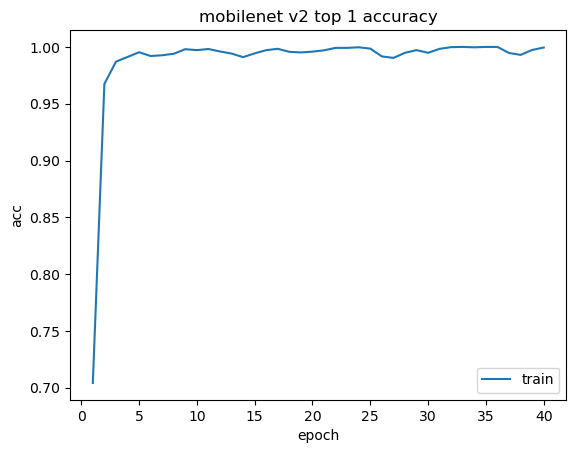

In [18]:
# 畫圖，只會畫前十個
# n = len(ckpt['history']['train_top1_accuracy'])
n = 40
epochs = range(1, n + 1)
plt.plot(epochs, ckpt['history']['train_top1_accuracy'][:n],label='train')
# plt.plot(epochs, ckpt['history']['valid_top1_accuracy'][:n],label='valid')
# plt.xlim(50,)
# plt.ylim(0,0.1)
plt.legend()
plt.title('mobilenet v2 top 1 accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')


In [20]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

class TestDataset(Dataset):
    def __init__(self):
        self.data = pd.read_csv('data/test_in.csv')  # 從csv文件中讀取數據
        self.reshaped_data = torch.from_numpy(self.data.drop(['Serial No.'], axis=1).values.reshape(-1, 8, 2)).to(torch.float32)

    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        data = self.reshaped_data[idx]
        serial_no = self.data.iloc[idx, 0]  # 讀取 Serial No.
        return data, serial_no

# 建立測試資料集與 DataLoader
test_dataset = TestDataset()
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()  # 將模型設為評估模式
result = []  # 用來儲存結果的list

with torch.no_grad():  # 不需要計算梯度，可以節省記憶體
    for data, serial_no in test_dataloader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)  # 預測出最大機率的類別
        result.append([serial_no.item(), predicted.item()])  # 將 Serial No. 與預測的類別加入 result list

# 將結果寫入 csv 文件
result_df = pd.DataFrame(result, columns=['Serial No.', 'Label'])
result_df.to_csv(f'runs/exp{name}/result.csv', index=False)


ValueError: not enough values to unpack (expected 2, got 1)

In [18]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms

class TestDatasetv2(Dataset):
    def __init__(self):
        self.data = pd.read_csv('data/test_in.csv')  # 從csv文件中讀取數據
        self.reshaped_data = torch.from_numpy(self.data.drop(['Serial No.'], axis=1).values.reshape(-1, 8, 2)).to(torch.float32)

        # 圖像轉換，可以根據實際情況修改
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 正則化
        ])
        
    def __len__(self):
        return len(self.data)  # 返回數據集的大小

    def __getitem__(self, idx):
        data = self.reshaped_data[idx]
        serial_no = self.data.iloc[idx, 0]  # 讀取 Serial No.
        
        # 加載圖像，並轉換為Tensor
        img_name = f"data/img_test_in/{idx}.png"
        img = Image.open(img_name).resize((120, 160)).convert("RGB")
        img = self.transform(img)
        
        return (data, img), serial_no  # 返回序列、圖像和標籤

# 建立測試資料集與 DataLoader
test_dataset = TestDatasetv2()
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()  # 將模型設為評估模式
result = []  # 用來儲存結果的list

with torch.no_grad():  # 不需要計算梯度，可以節省記憶體
    for data, serial_no in test_dataloader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)  # 預測出最大機率的類別
        result.append([serial_no.item(), predicted.item()])  # 將 Serial No. 與預測的類別加入 result list

# 將結果寫入 csv 文件
result_df = pd.DataFrame(result, columns=['Serial No.', 'Label'])
result_df.to_csv(f'runs/exp{name}/result.csv', index=False)


In [27]:
import pandas as pd
from functools import reduce
import pandas as pd
import numpy as np
import random

# 建立 DataFrame 列表
# ls = [4, 16, 18, 19, 13, 15, 4]
ls = [4, 30, 31]
dfs = [pd.read_csv(f'runs/exp{x}/result.csv') for x in ls]

# 為每個 DataFrame 的欄位名稱添加後綴
for i, df in enumerate(dfs):
    df.columns = [f"{col}_{i}" if col != 'Serial No.' else col for col in df.columns]

# 使用 reduce 函數和 merge 合併所有 DataFrame，並設定欄位後綴
df = reduce(lambda left,right: pd.merge(left, right, on='Serial No.'), dfs)

# 創建一個新的欄位 'Label_diff'，並檢查每一行的 Label 欄位的值是否有不同
df['Label_diff'] = df.apply(lambda row: 1 if len(set(row[1:])) > 1 else 0, axis=1)

# 創建一個新的欄位 'Label_vote'，並檢查每一行的 Label 欄位的投票結果
df['Label_vote'] = df.apply(lambda row: random.choice([k for k, v in pd.Series(row[1:-1]).value_counts().items() 
    if v == pd.Series(row[1:-1]).value_counts().max()]), axis=1)

print(df['Label_diff'].sum())

df
df.to_csv(increment_path('result.csv'), index=False)

105


In [22]:
df_diff = df[df['Label_diff'] == 1]
df_diff
df_diff.to_csv(increment_path('result.csv'), index=False)

In [22]:
df_diff_2 = df[df['Label_0'] != df['Label_vote']]
df_diff_2

,Serial No.,Label_0,Label_1,Label_2,Label_3,Label_4,Label_diff,Label_vote
289,290,1,2,2,2,1,1,2
291,292,2,7,7,1,2,1,7
603,604,1,9,5,9,1,1,9
627,628,6,0,0,0,6,1,0
862,863,2,6,6,6,2,1,6
1274,1275,5,9,9,9,5,1,9
1300,1301,5,9,9,9,5,1,9
1580,1581,5,9,9,9,5,1,9
1904,1905,6,8,8,2,6,1,8
1954,1955,2,7,7,1,2,1,7


In [31]:
df = pd.read_csv(f'result4.csv')
df

,Serial No.,Label_0,Label_1,Label_2,Label_diff,Label_vote
0,1,8,8,8,0,8
1,2,8,8,8,0,8
2,3,8,8,8,0,8
3,4,9,9,9,0,9
4,5,9,9,9,0,9
...,...,...,...,...,...,...
3493,3494,4,4,4,0,4
3494,3495,2,2,2,0,2
3495,3496,0,0,0,0,0
3496,3497,0,0,0,0,0


In [32]:
# 創建一個新的 DataFrame，只包含 'Serial No.' 和 'Label_vote' 兩個欄位，並將 'Label_vote' 改名為 'Label'
df_res = df[['Serial No.', 'Label_vote']].rename(columns={'Label_vote': 'Label'})
df_res.to_csv(increment_path('result.csv'), index=False)
df_res

,Serial No.,Label
0,1,8
1,2,8
2,3,8
3,4,9
4,5,9
...,...,...
3493,3494,4
3494,3495,2
3495,3496,0
3496,3497,0


In [28]:
data = pd.read_csv('data/test_in.csv')  # 從csv文件中讀取數據
# data = pd.read_csv('data/train_in.csv')  # 從csv文件中讀取數據
# labels = pd.read_csv('data/train_out.csv')  # 從csv文件中讀取數據
labels = pd.read_csv('result4.csv')  # 從csv文件中讀取數據
reshaped_data = data.drop(['Serial No.'], axis=1).values.reshape(-1, 8, 2)
# print(reshaped_data[0])

In [22]:
import matplotlib.pyplot as plt

for i in range(0, len(data)):

    # 假設你有8個座標點，每個點都有x和y兩個座標
    points = reshaped_data[i]
    # label = labels.iloc[i, 1]
    # print()
    
    
    # 分解為x座標和y座標
    x = [point[0] for point in points]
    y = [point[1] for point in points]

    # 繪製座標點
    plt.scatter(x, y, s=300)

    # 獨立繪製第一個點，以綠色表示
    plt.scatter(x[0], y[0], color='green', s=500)

    # 獨立繪製最後一個點，以藍色表示
    plt.scatter(x[-1], y[-1], color='blue', s=500)

    # 繪製連接座標點的線
    plt.plot(x, y, color='red', linewidth=3)

    # 設定x軸和y軸的範圍
    plt.xlim(-5, 105)
    plt.ylim(-5, 105)
    # plt.title(f"{i}_{label}")
    # plt.title(f"{i+2}")

    # 顯示圖表
    plt.savefig(f'data/img_test_in/{i}.png')
    plt.close()

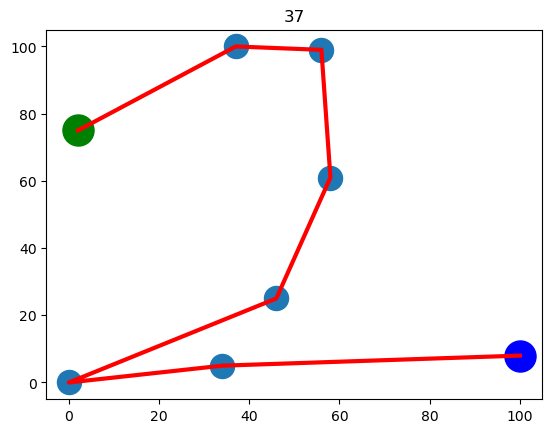

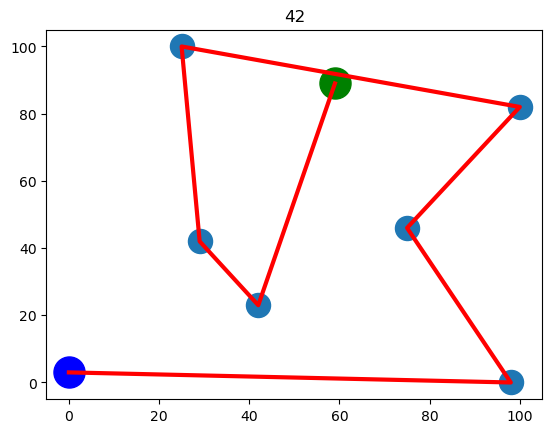

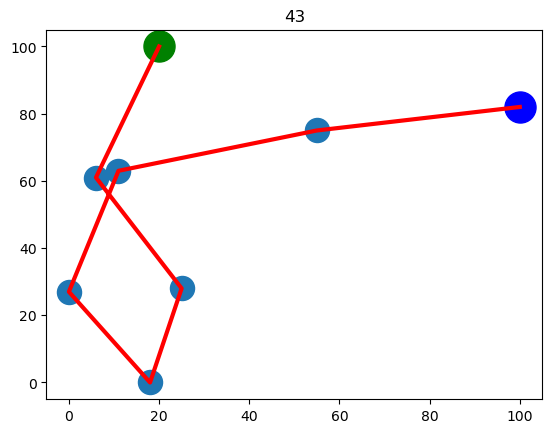

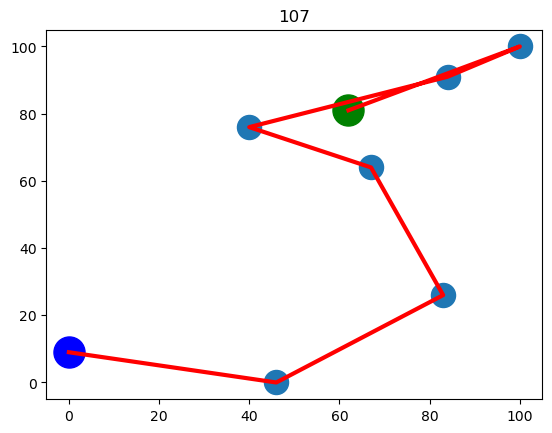

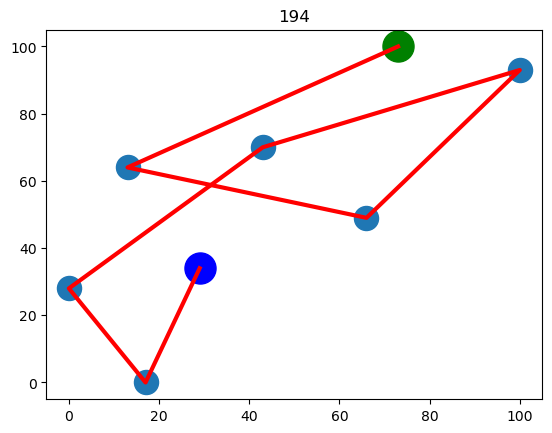

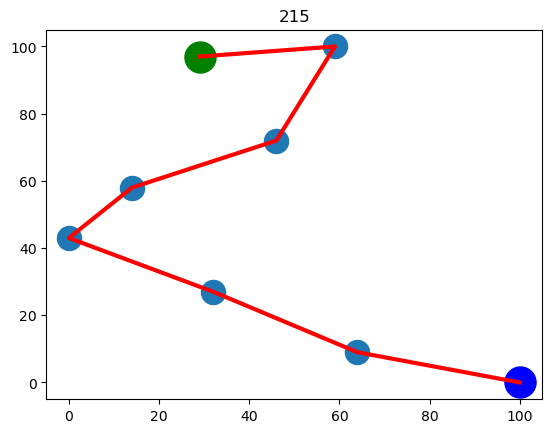

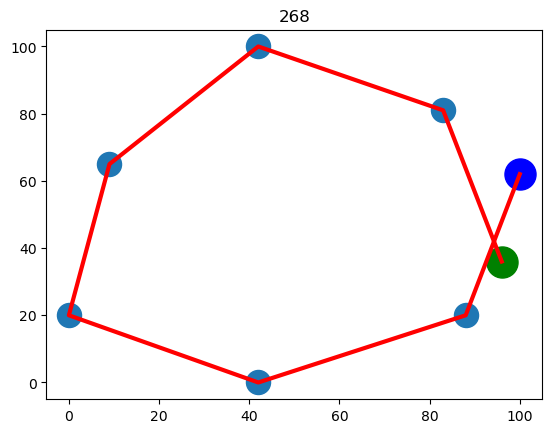

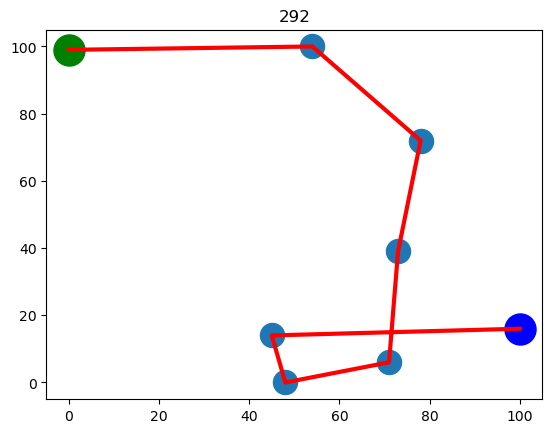

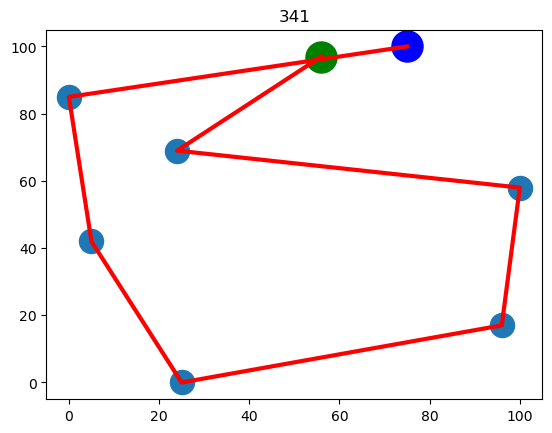

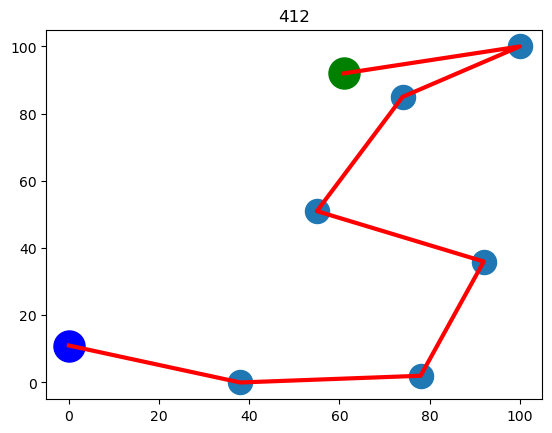

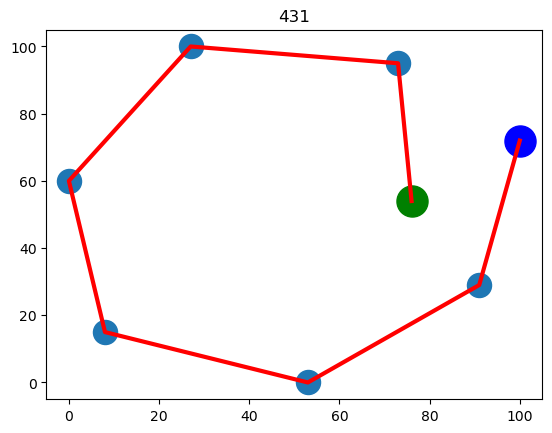

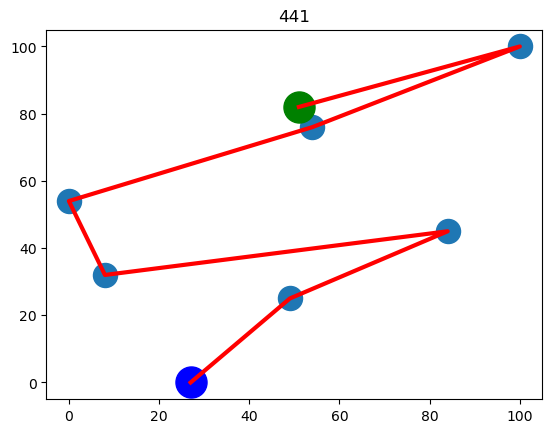

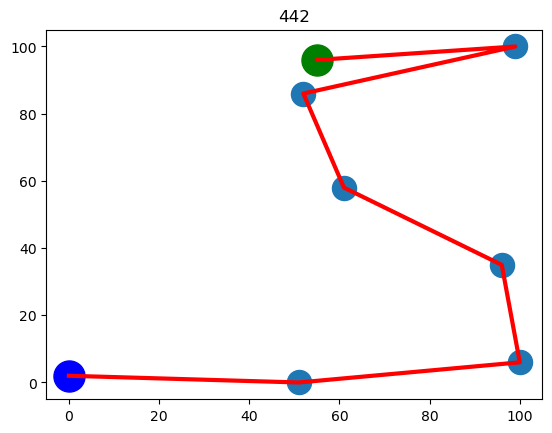

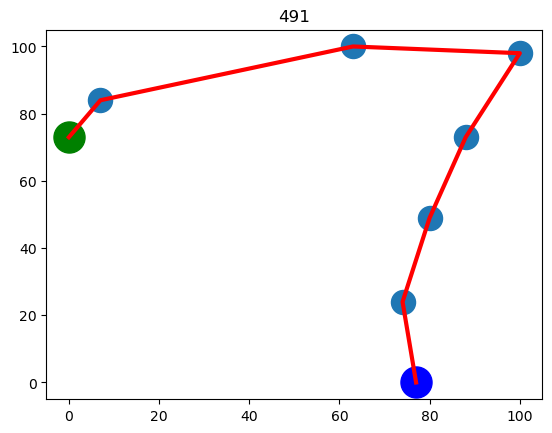

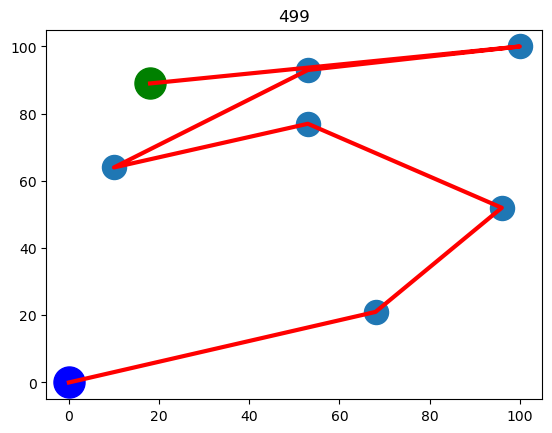

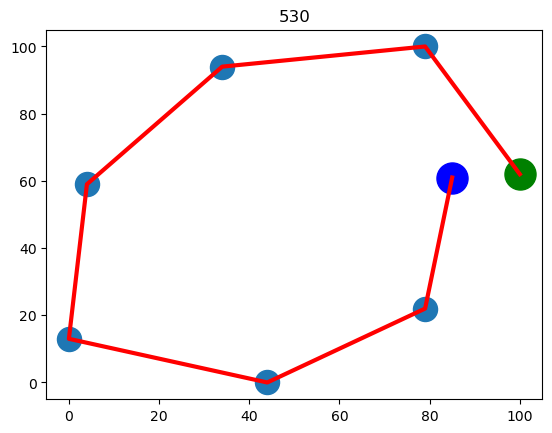

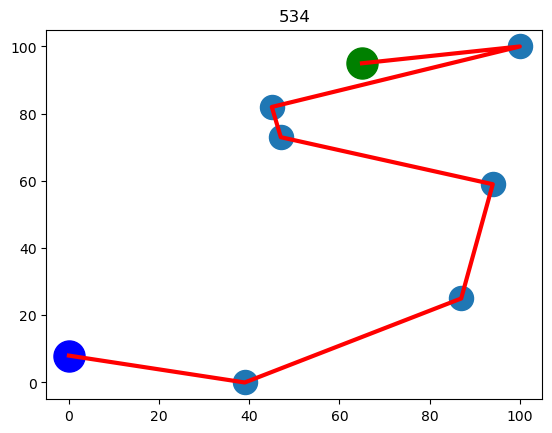

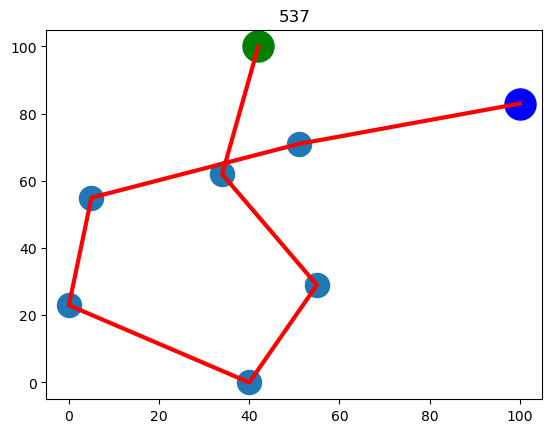

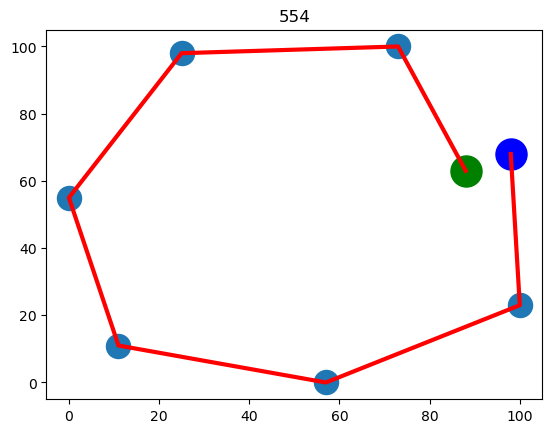

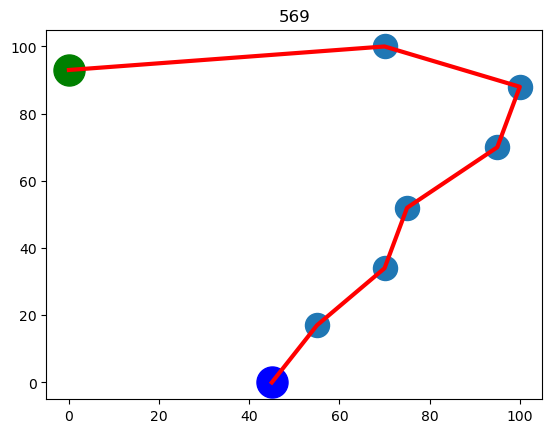

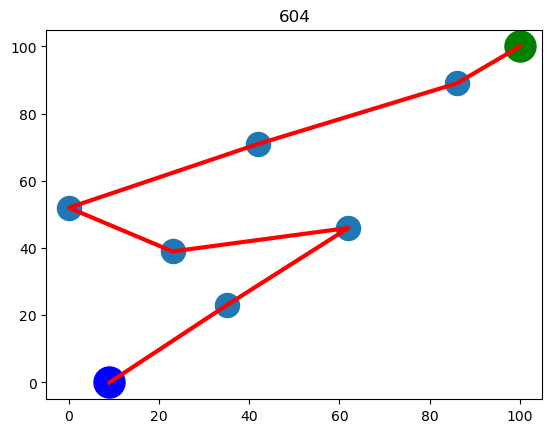

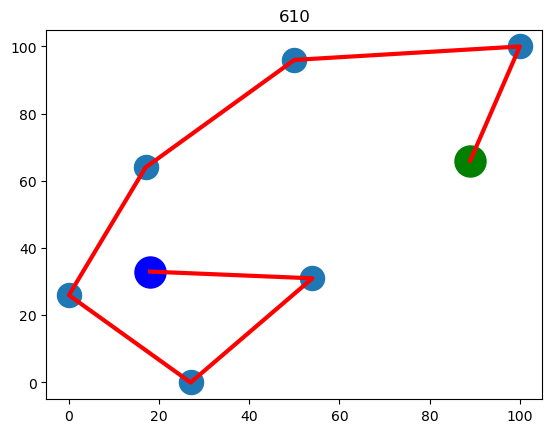

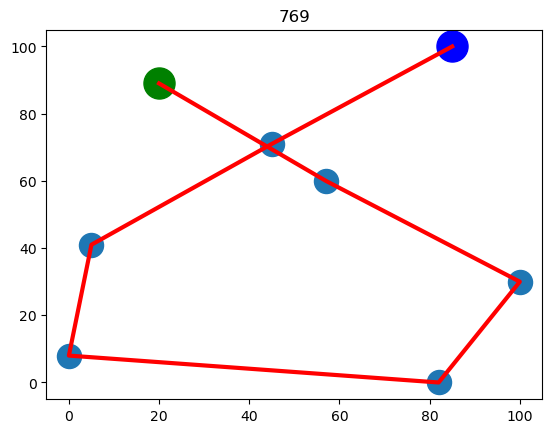

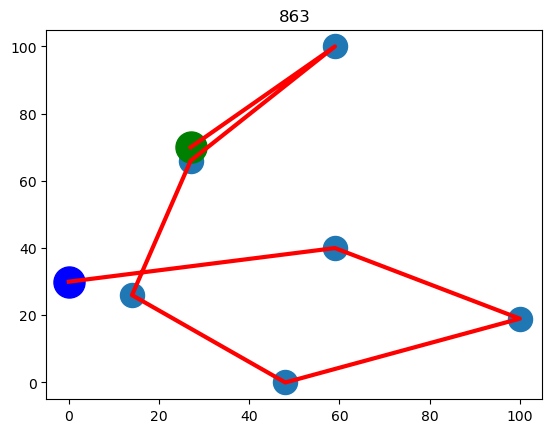

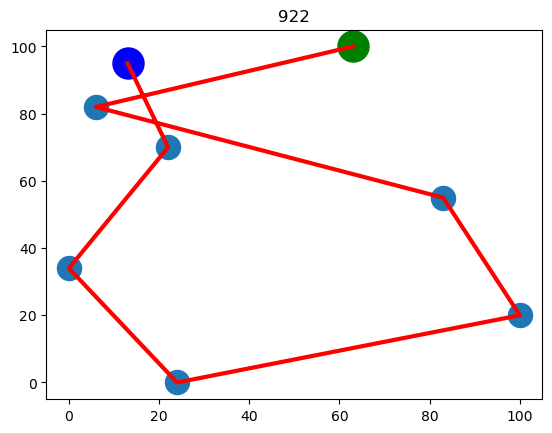

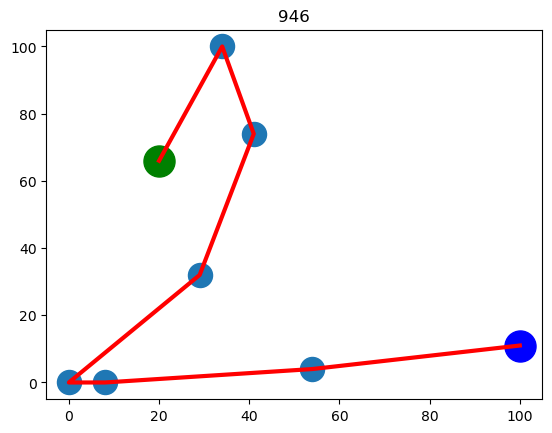

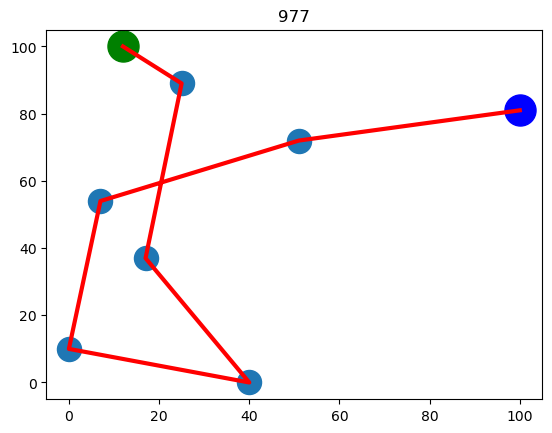

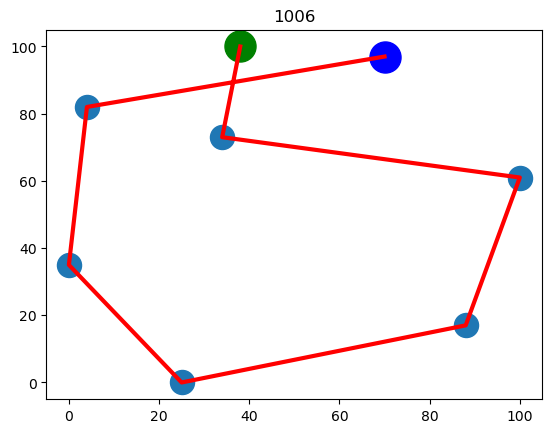

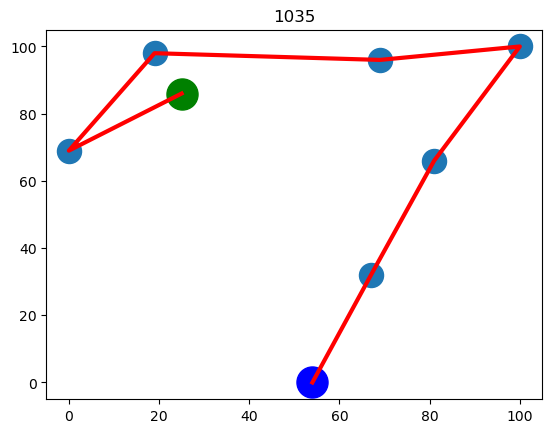

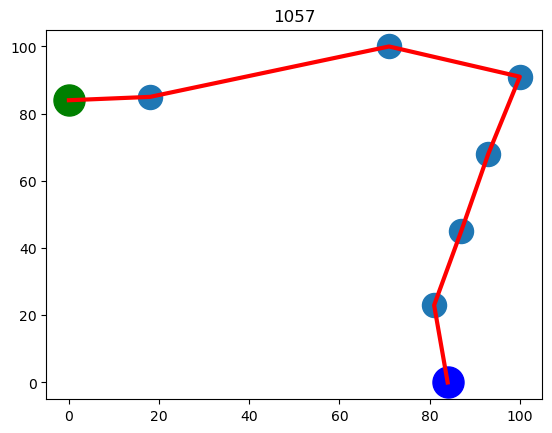

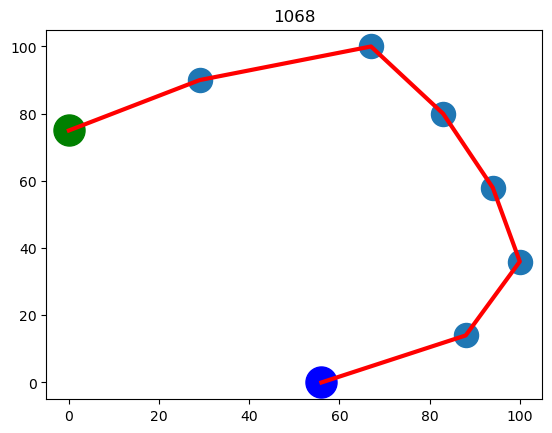

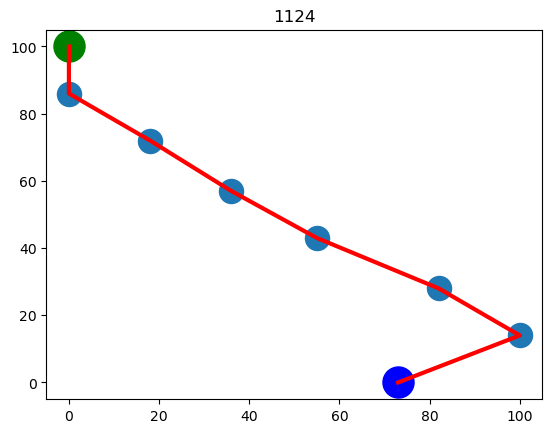

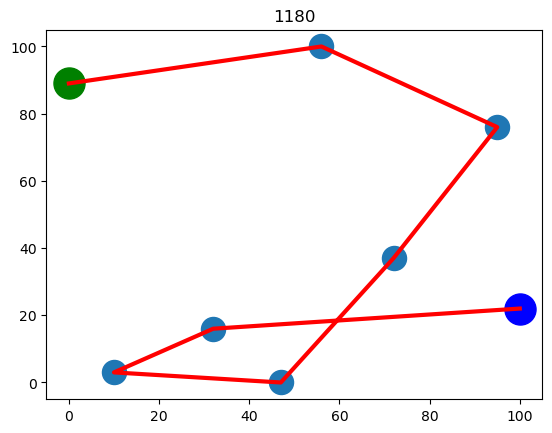

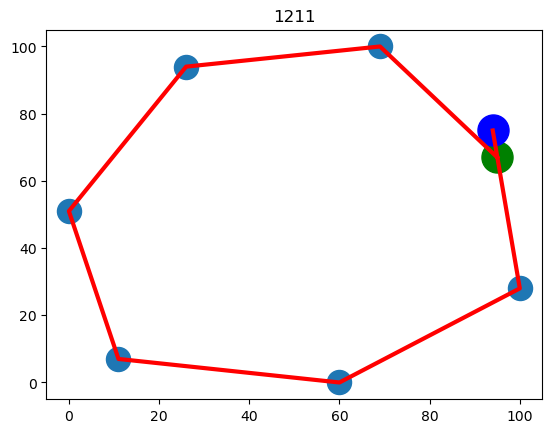

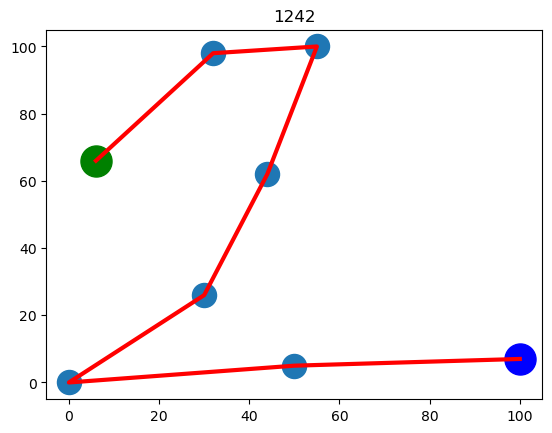

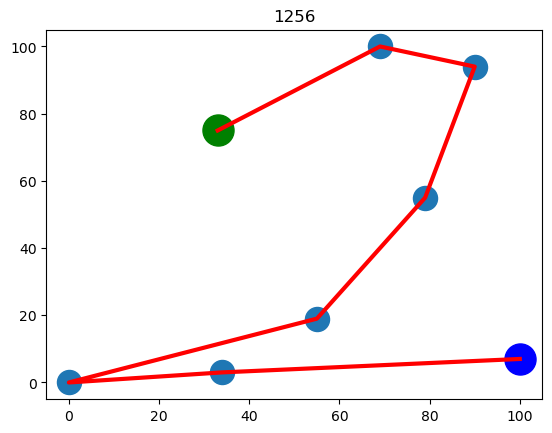

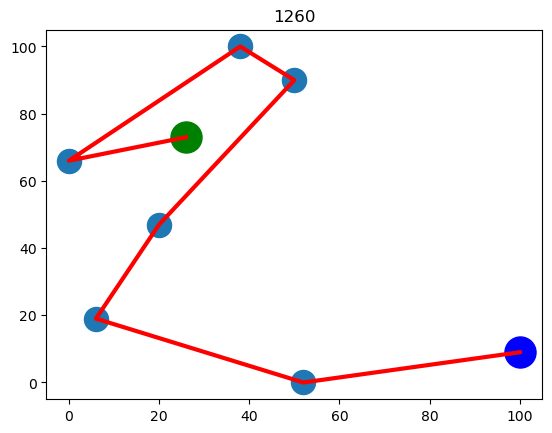

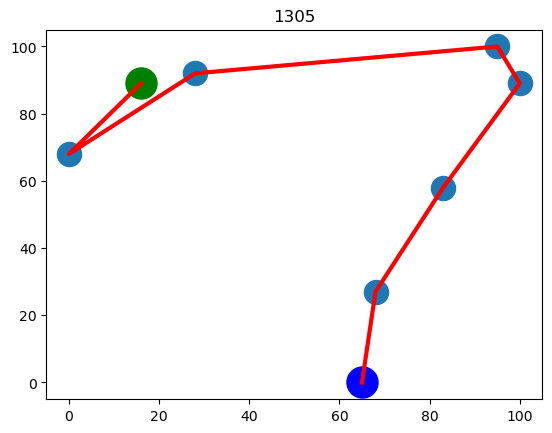

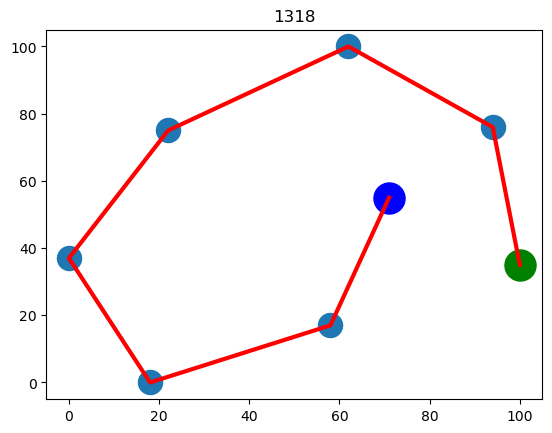

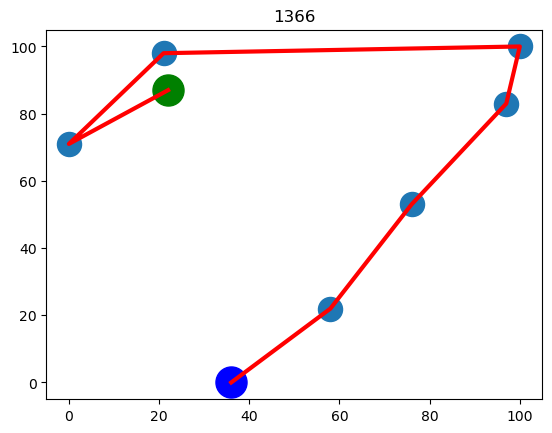

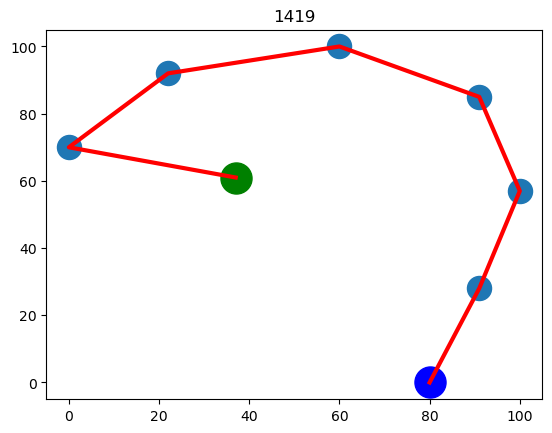

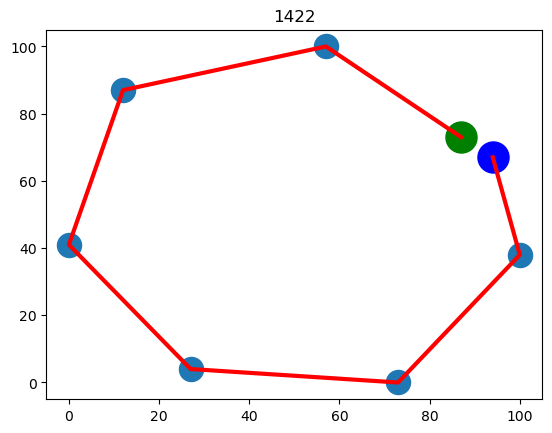

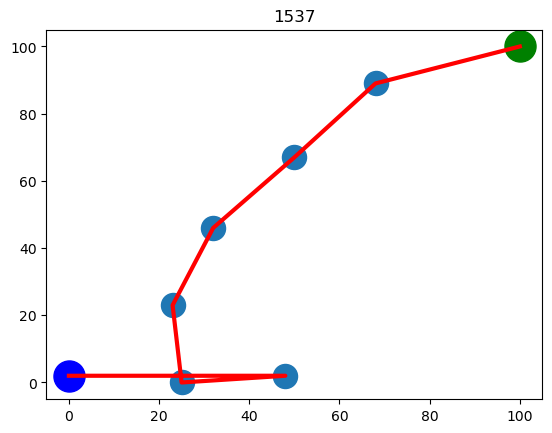

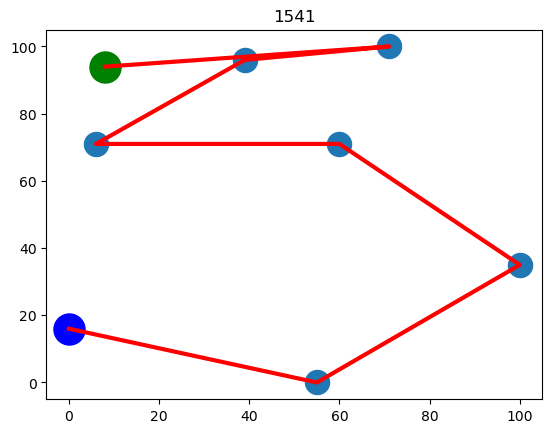

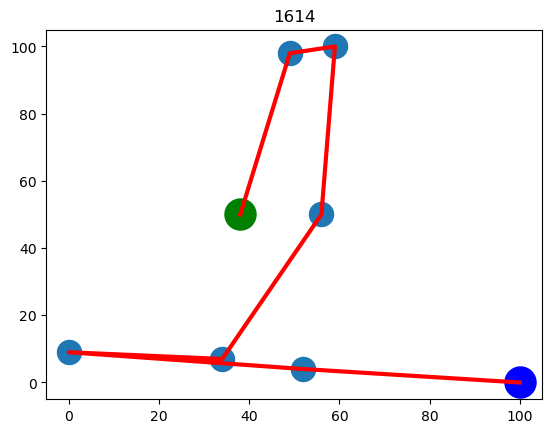

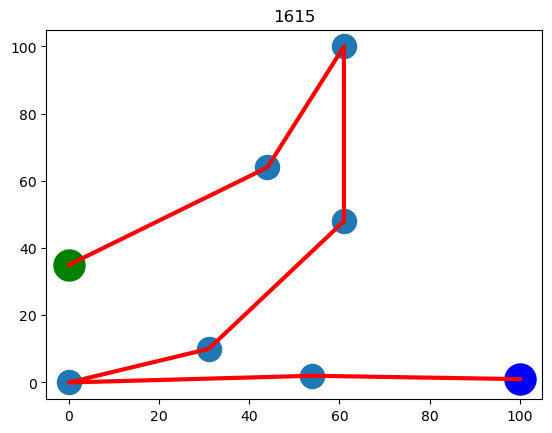

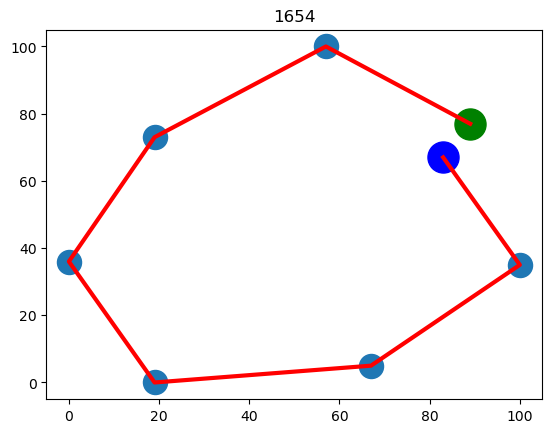

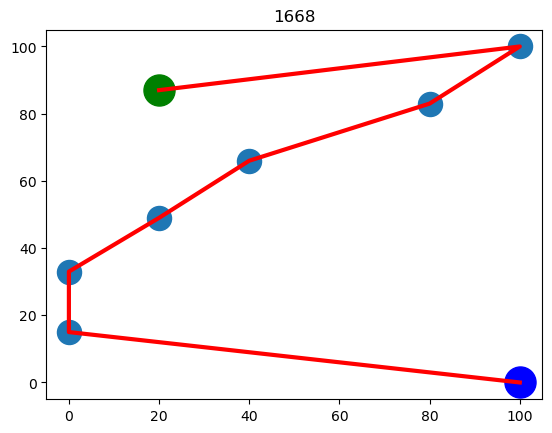

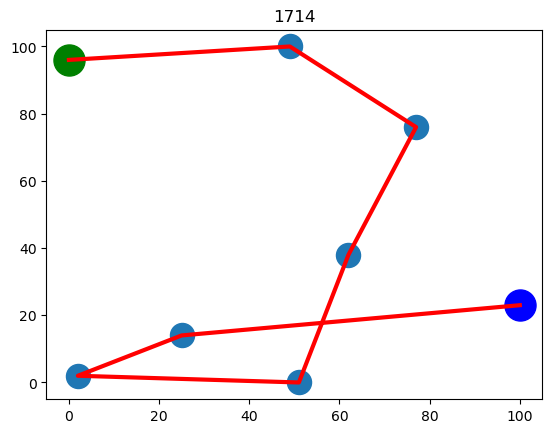

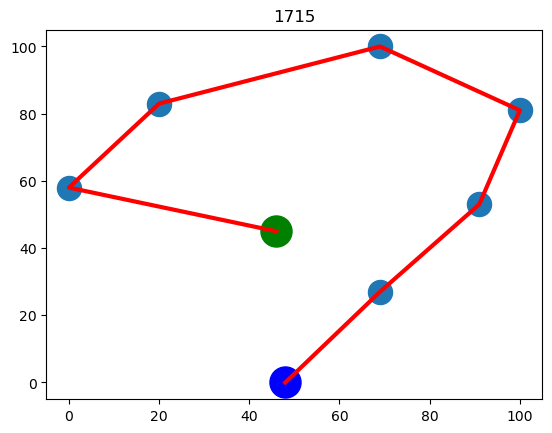

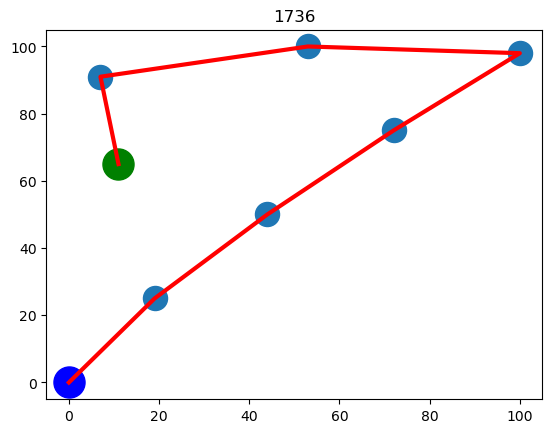

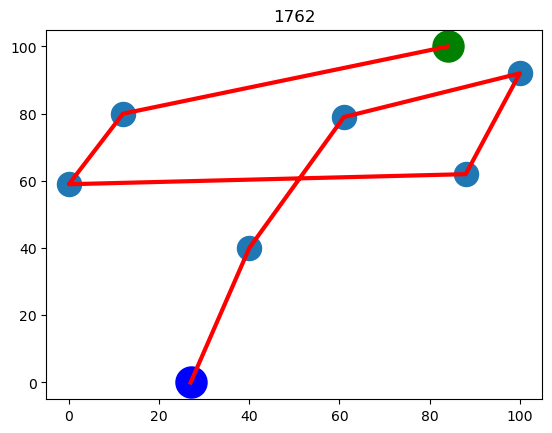

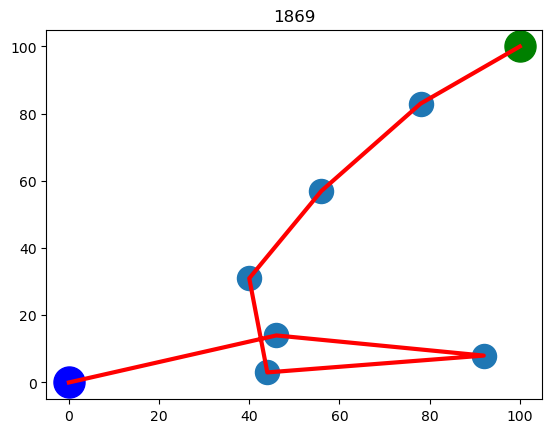

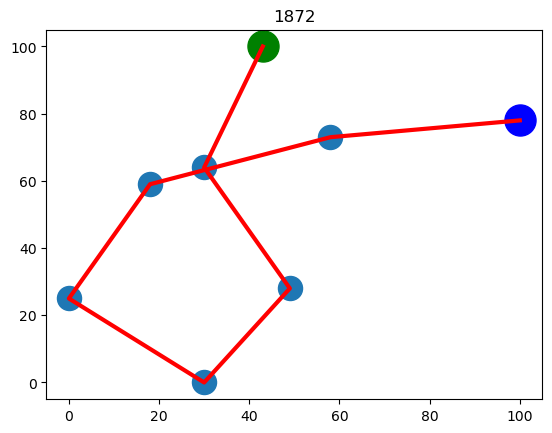

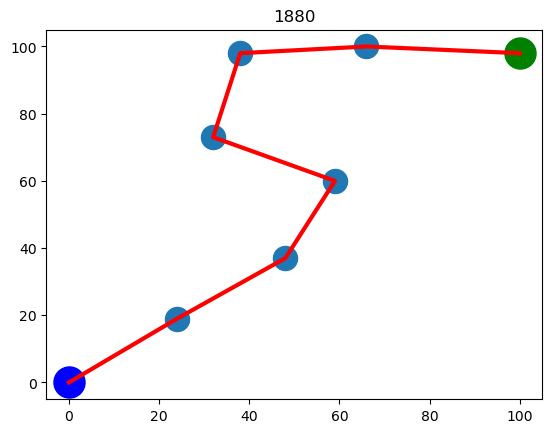

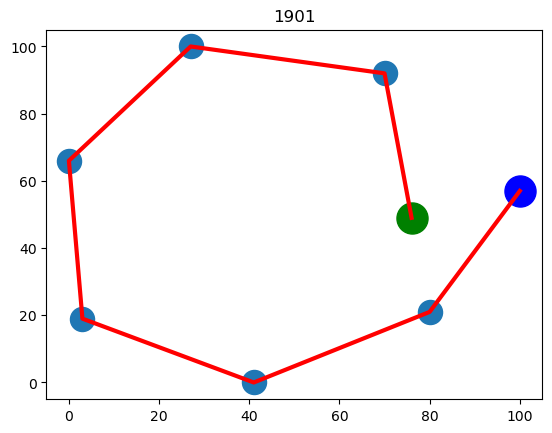

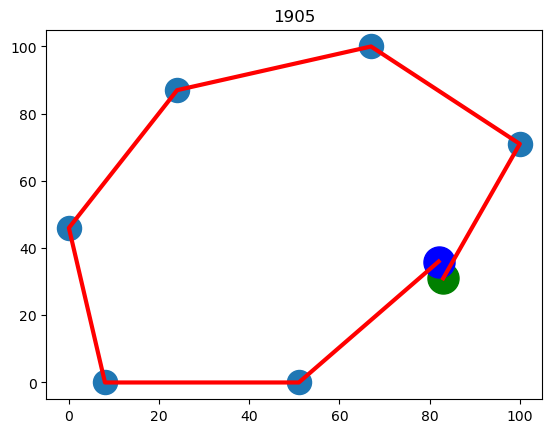

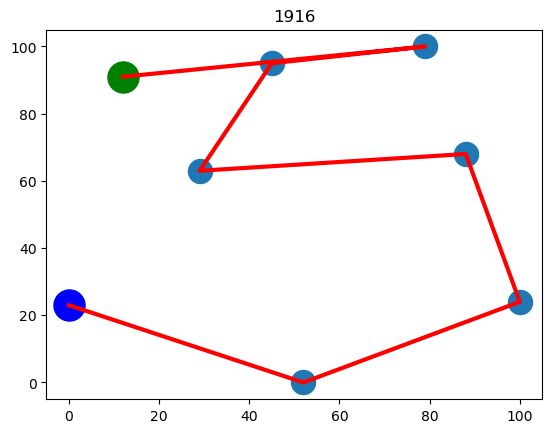

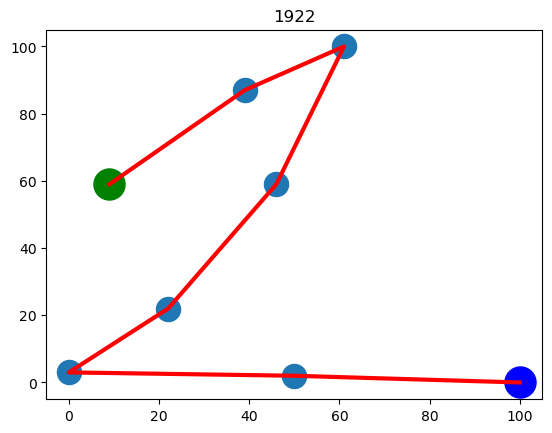

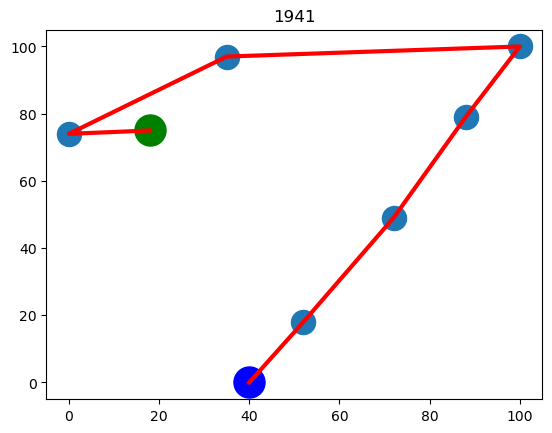

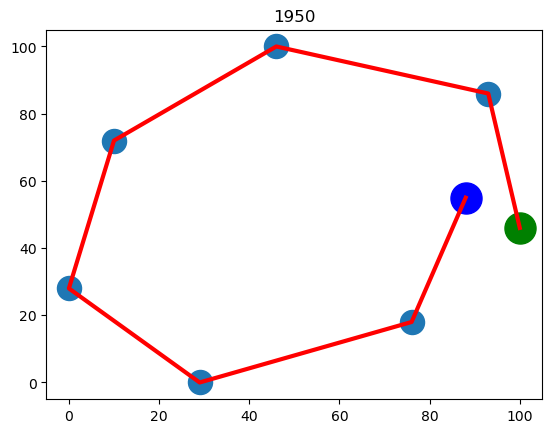

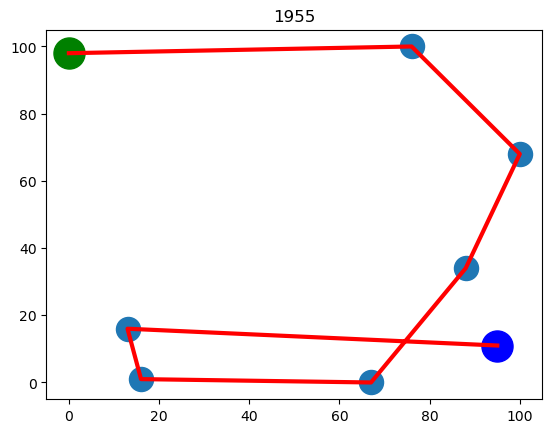

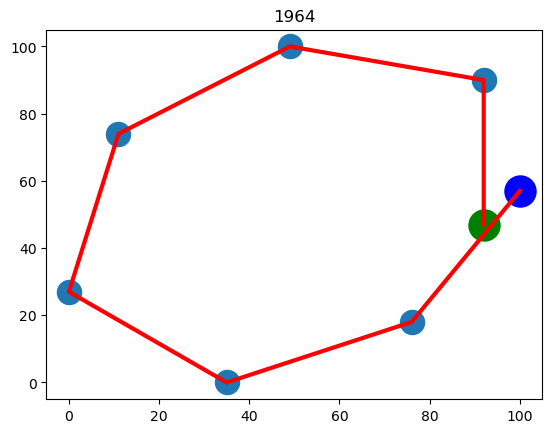

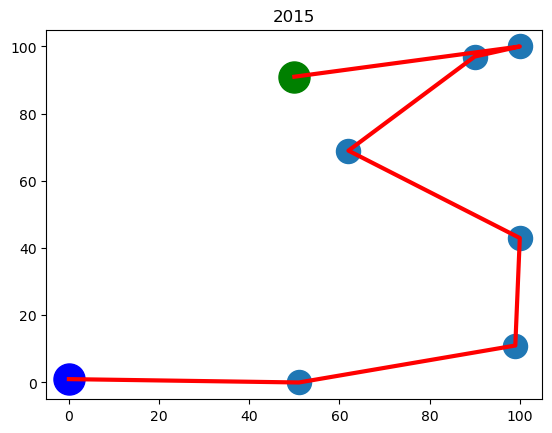

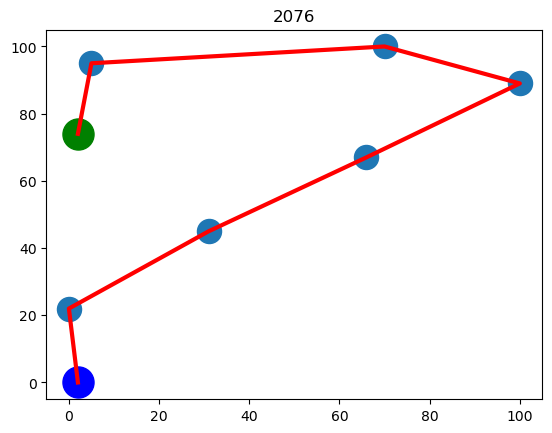

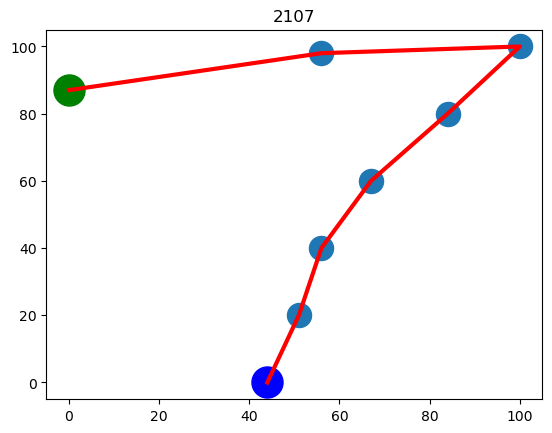

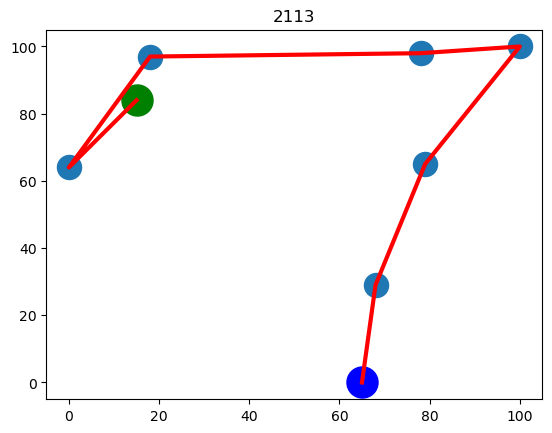

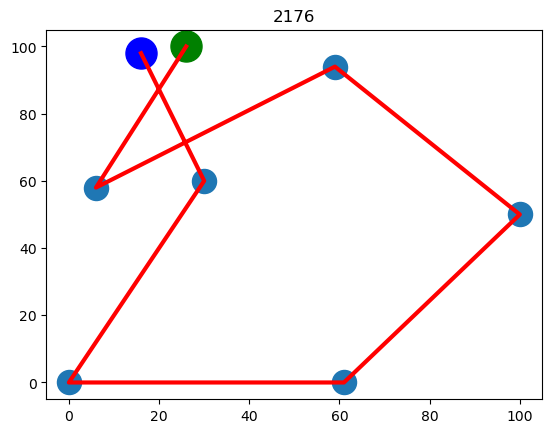

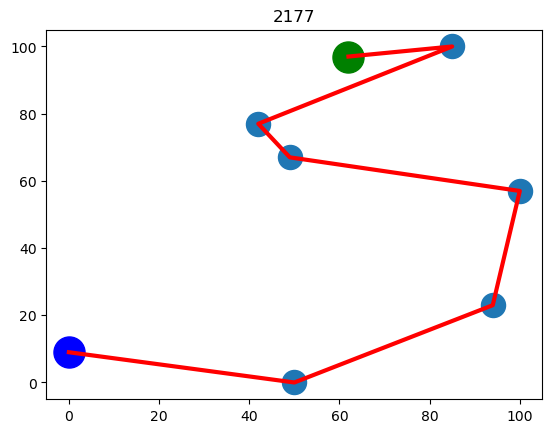

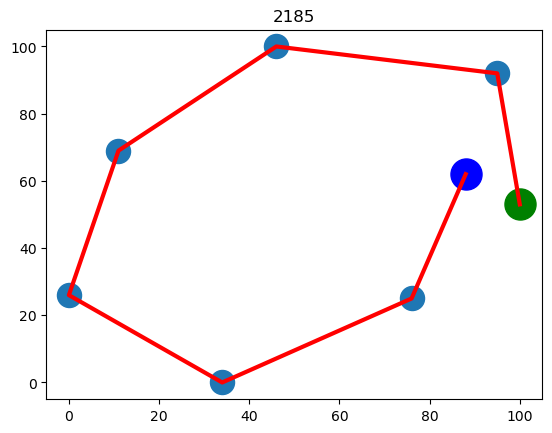

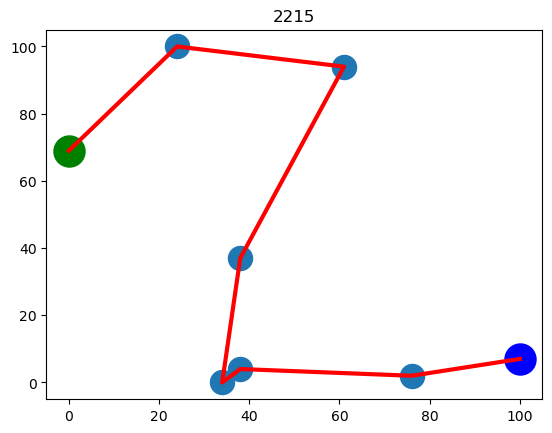

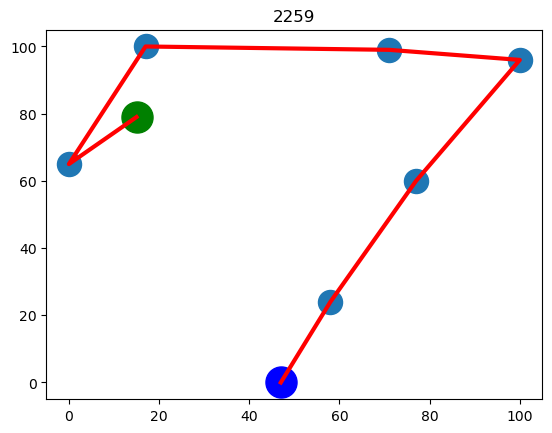

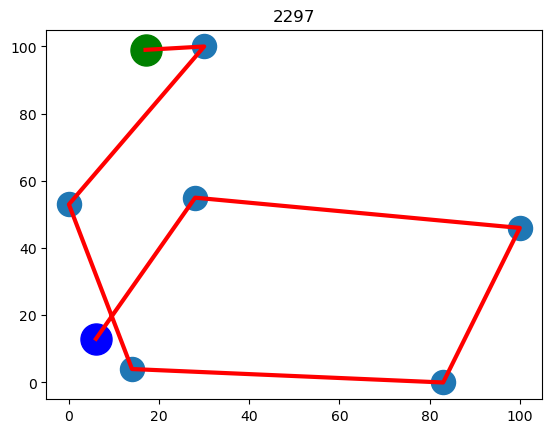

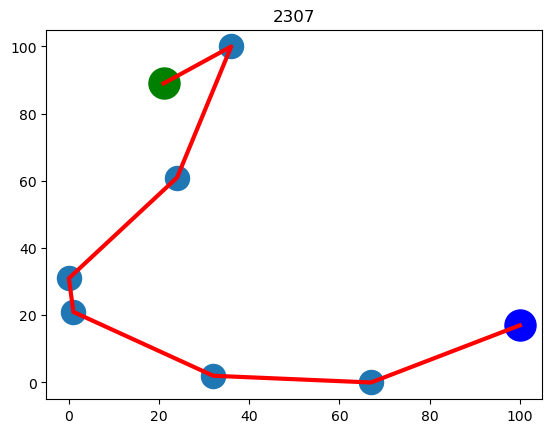

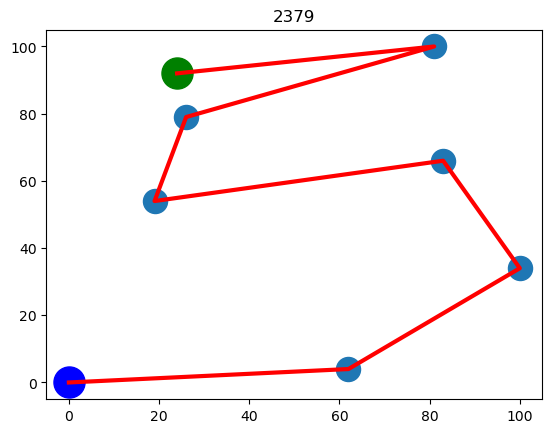

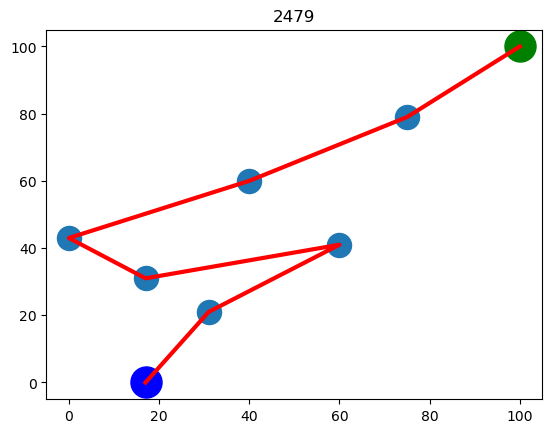

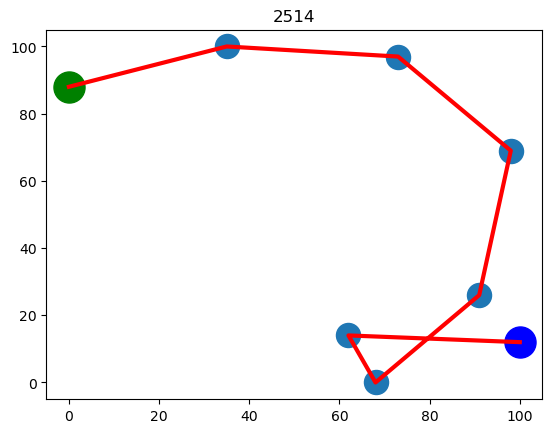

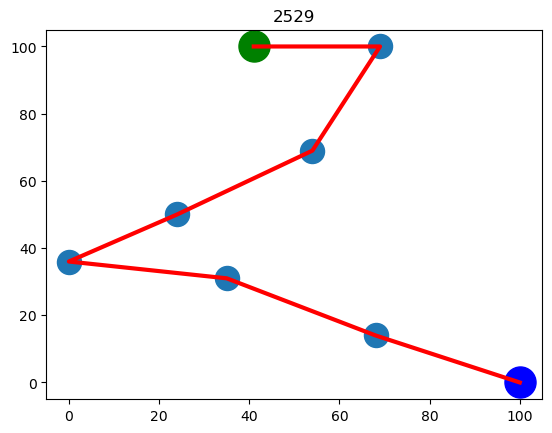

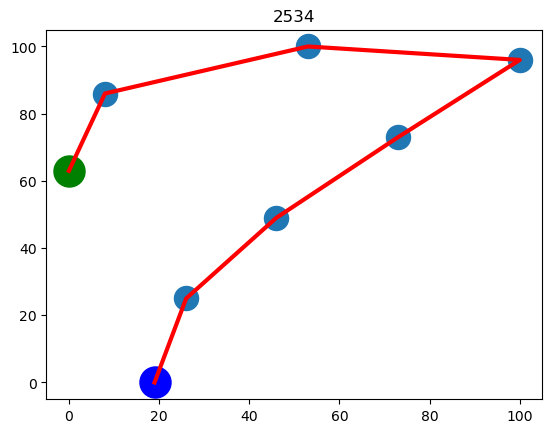

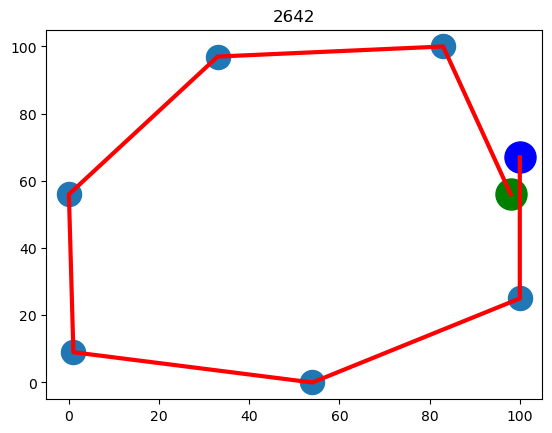

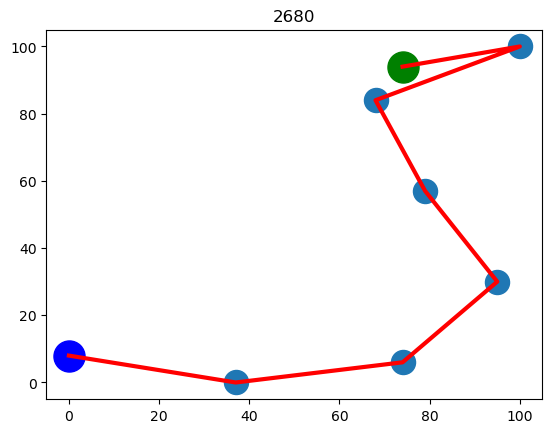

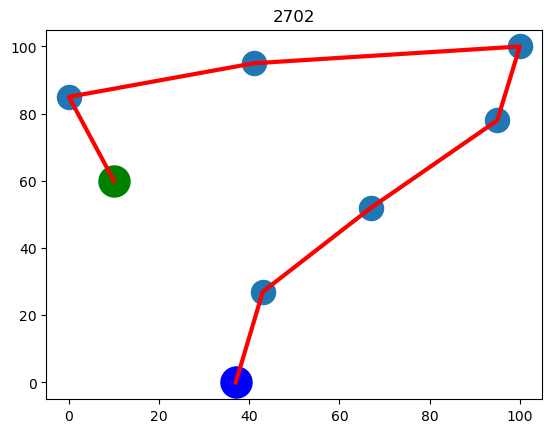

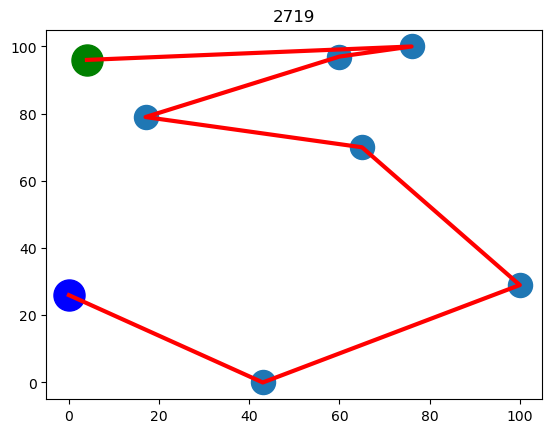

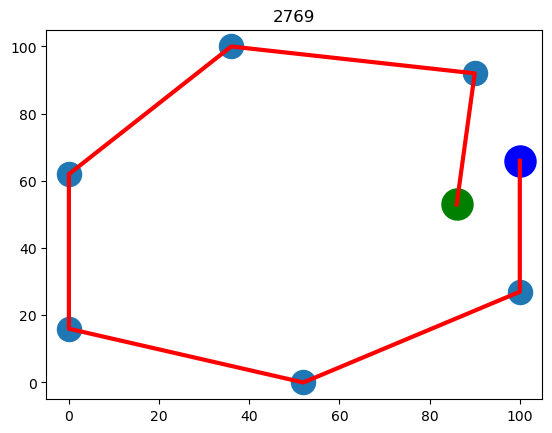

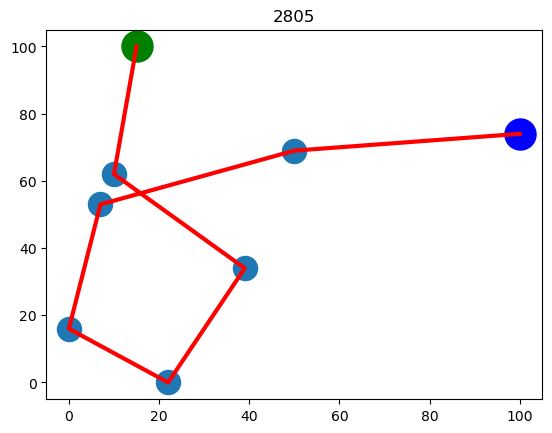

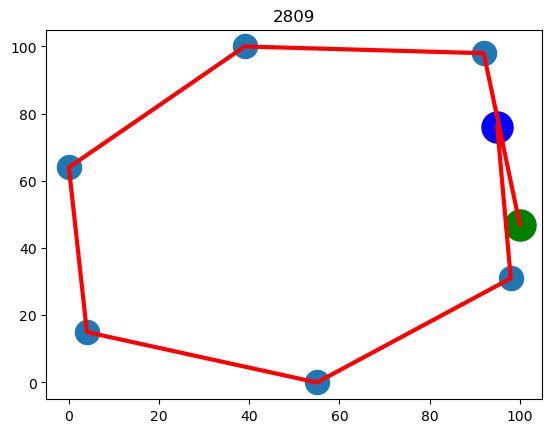

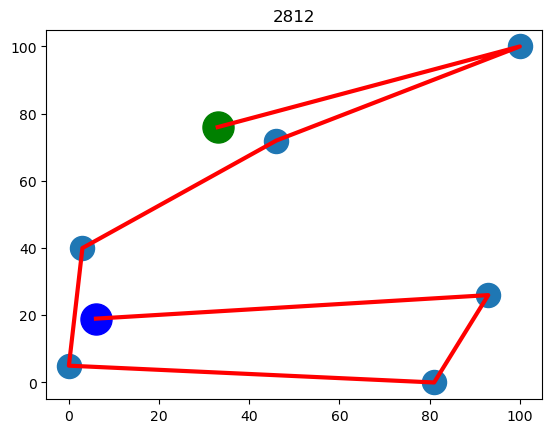

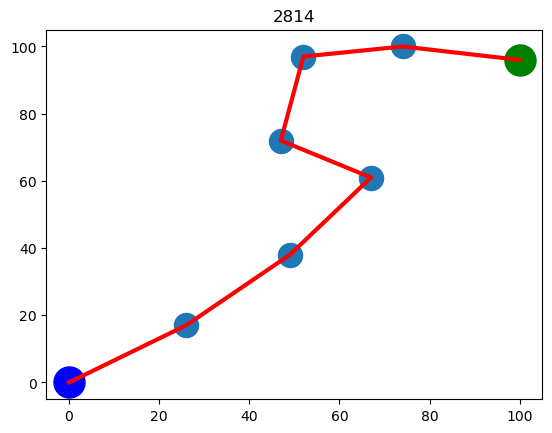

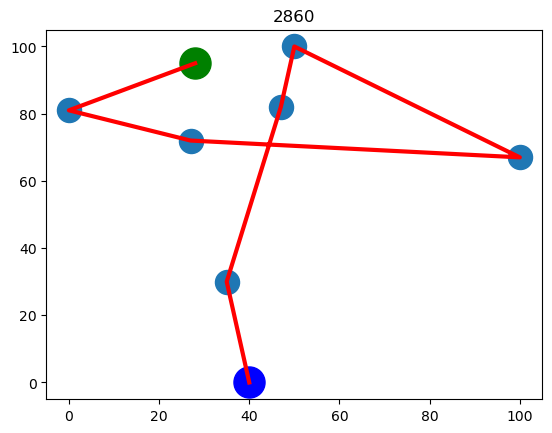

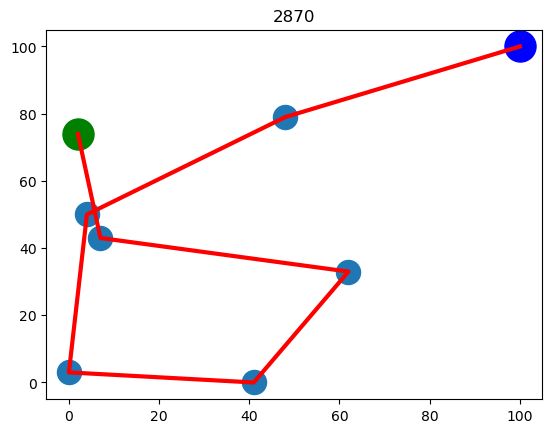

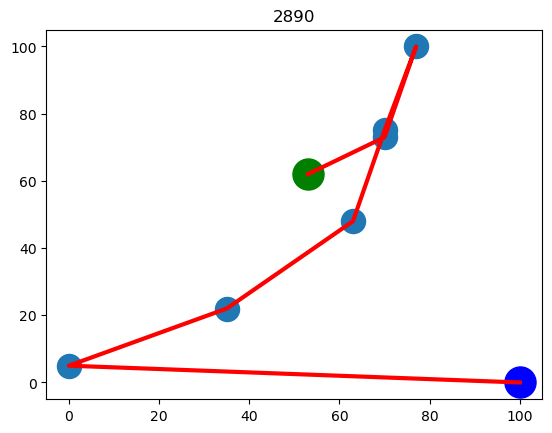

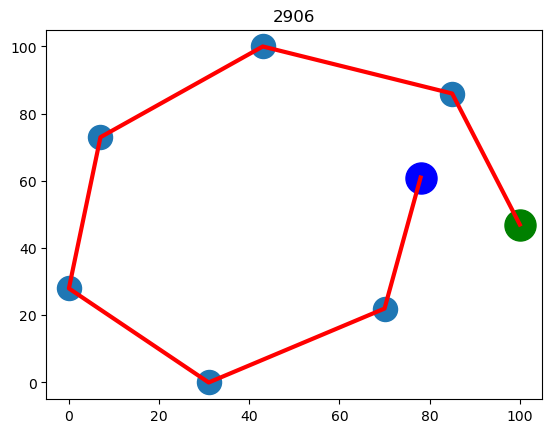

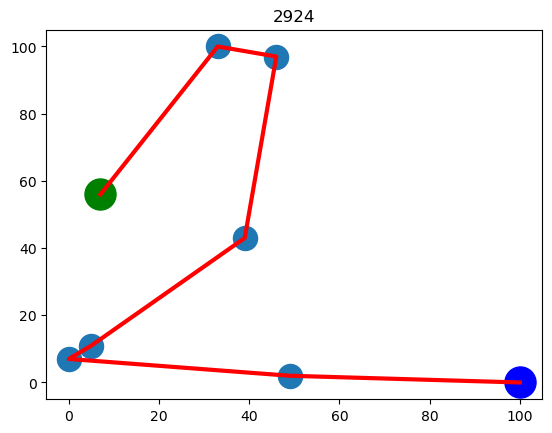

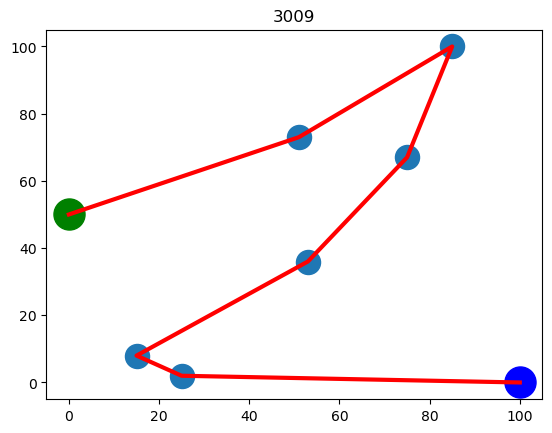

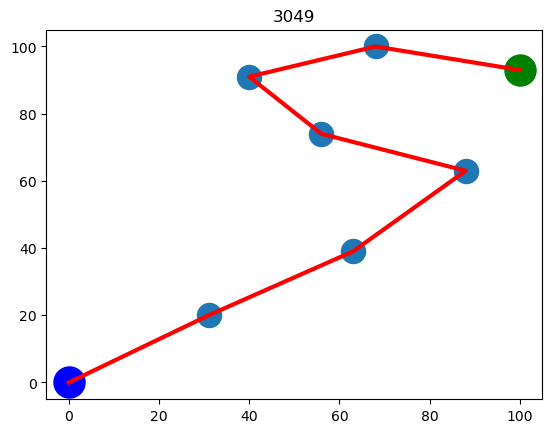

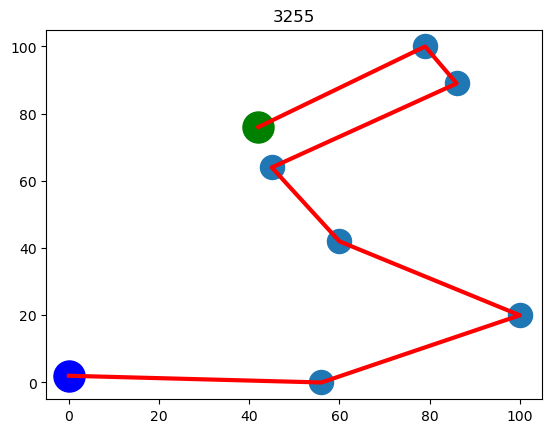

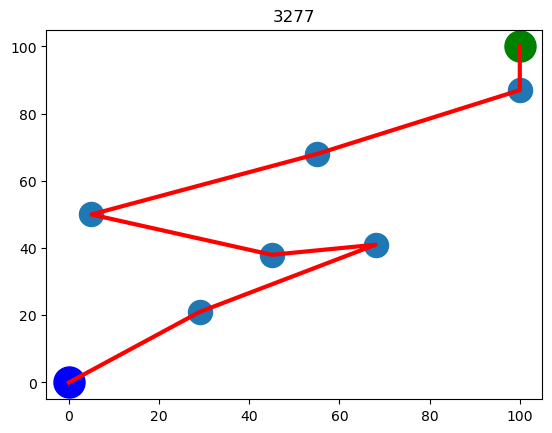

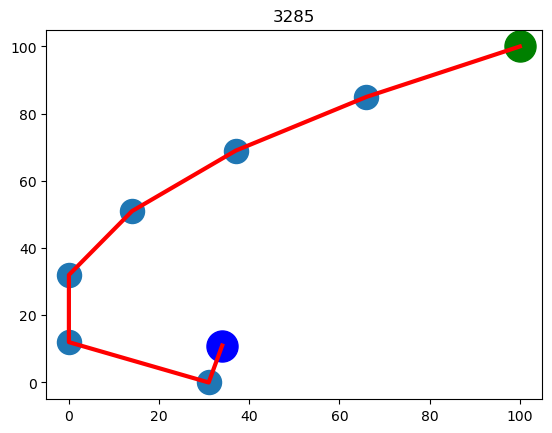

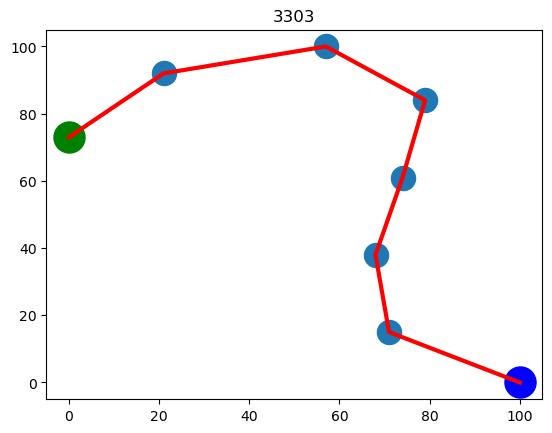

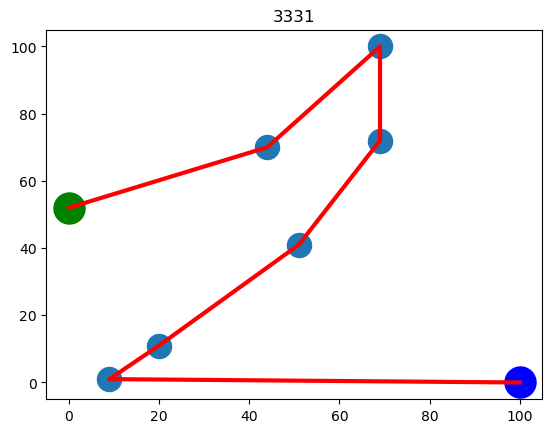

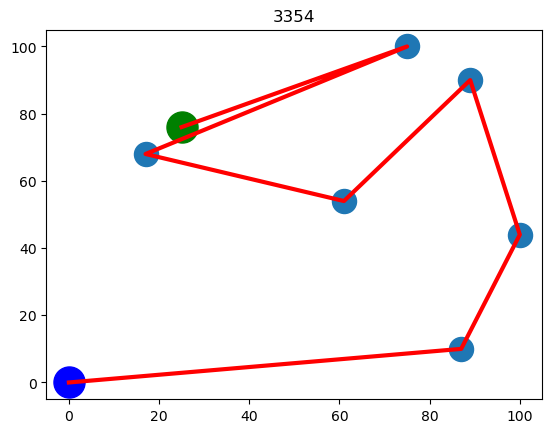

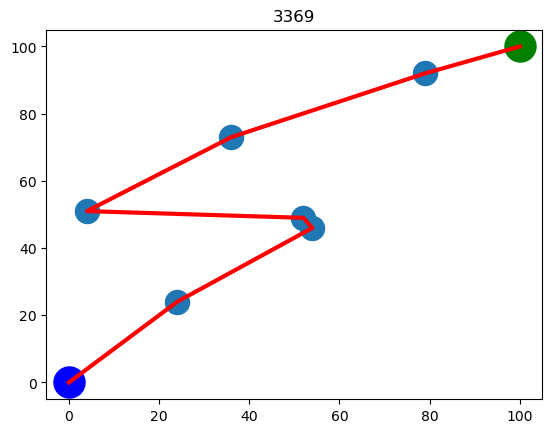

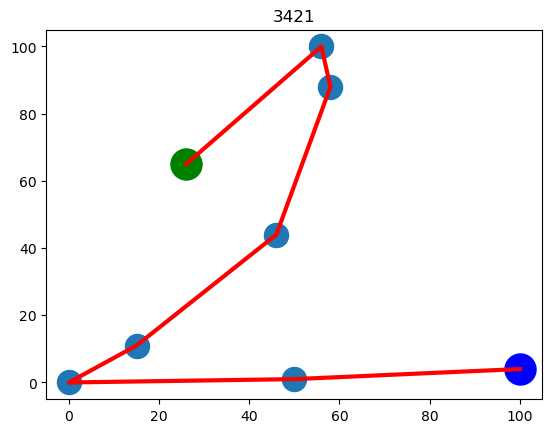

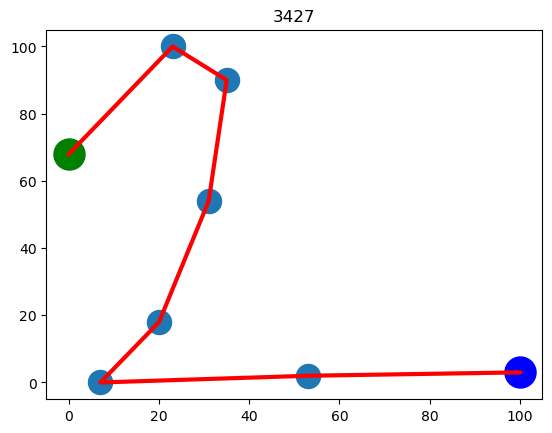

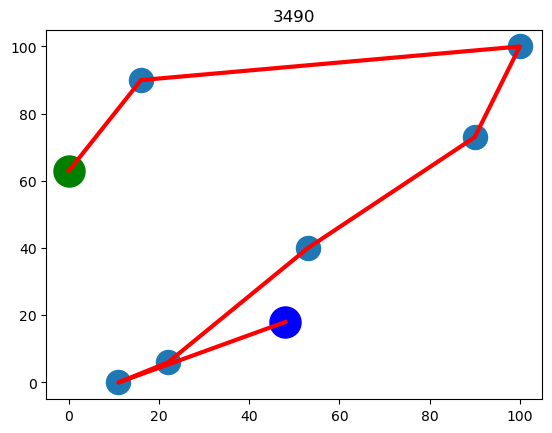

In [29]:
import matplotlib.pyplot as plt

for i in range(0, len(data)):

    # 假設你有8個座標點，每個點都有x和y兩個座標
    points = reshaped_data[i]
    label = labels.iloc[i, 1]
    # print()
    
    if (int(labels.iloc[i, 4]) == 1):
        # 分解為x座標和y座標
        x = [point[0] for point in points]
        y = [point[1] for point in points]

        # 繪製座標點
        plt.scatter(x, y, s=300)

        # 獨立繪製第一個點，以綠色表示
        plt.scatter(x[0], y[0], color='green', s=500)

        # 獨立繪製最後一個點，以藍色表示
        plt.scatter(x[-1], y[-1], color='blue', s=500)

        # 繪製連接座標點的線
        plt.plot(x, y, color='red', linewidth=3)

        # 設定x軸和y軸的範圍
        plt.xlim(-5, 105)
        plt.ylim(-5, 105)
        # plt.title(f"{i}_{label}")
        plt.title(f"{i+1}")

        # 顯示圖表
        plt.show()

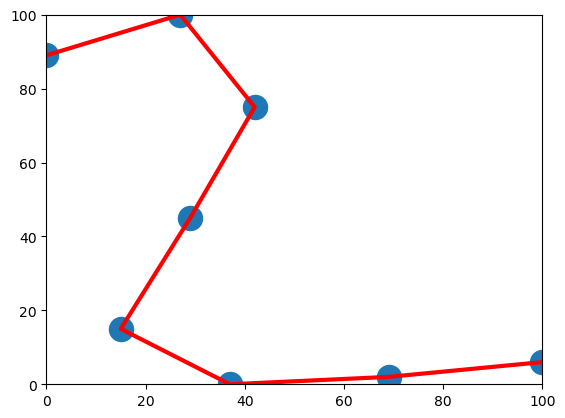

In [25]:


# 假設你有8個座標點，每個點都有x和y兩個座標
points = reshaped_data[1]

# 分解為x座標和y座標
x = [point[0] for point in points]
y = [point[1] for point in points]

# 繪製座標點
plt.scatter(x, y, s=300)

# 繪製連接座標點的線
plt.plot(x, y, color='red', linewidth=3)

# 設定x軸和y軸的範圍
plt.xlim(0, 100)
plt.ylim(0, 100)

# 顯示圖表
plt.show()
